<a href="https://colab.research.google.com/github/EVA6-Group-15/MNIST_99_4/blob/master/MNIST_99_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Achieve 99.4 Validation Accuracy on MNIST Dataset

The goal is to achieve 99.4 validation accuracy on MNIST dataset. Few constraints are: 
1. maintain total number of parameters of the network below 20k.
2. Use Batch Normalization and Image Normalization techniques.
3. Use Dropout layers.
4. Use data augmentation if necessary.
5. Total number of Epochs must be less than 19.


In [2]:
!pip install hiddenlayer

In [3]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Performing necessary imports

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

from torchvision import datasets, transforms

from torchsummary import summary

from tqdm.notebook import tqdm
import hiddenlayer as hl

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## Define Train and Test functions

### Function to train model

In [6]:
# Function to be used for training the model
def train_network(model, device, train_loader, optimizer):
    """
    train_network: Function defined to train a model.

    Model training is performed considering the multiple inputs like
    model, device on which training has to happen, optimizer to be
    used while training.

    Parameters:
    -----------
    model: Model architecture to be used to train the model.
    device: Type of device (GPU/CPU) to be used while training model.
    train_loader: Defining which DataLoader to be used for training.
    optimizer: Defining which optimizer to be used.

    Returns:
    --------
    train_loss: The loss observed while training the model.
    accuracy: Accuracy of the model over the current training data.
    """
    model.train()  # Setting model to train mode.
    progress_bar = tqdm(train_loader)  # Passing the training data loader through tqdm to divide the progress bar into x chucks
    train_loss = 0  # Initializing training loss
    correct_count = 0  # Initializing correct count to calculate the accuracy

    for batch_idx, (data, target) in enumerate(progress_bar):
        data, target = data.to(device), target.to(device)  # Moving data values to run on a chosen device
        optimizer.zero_grad()  # Setting optimizer value to zero to avoid accumulation of gradient values
        output = model(data)  # Training the model on the data on a total set of images whose count is equal to batch size
        loss = F.nll_loss(input=output, target=target)  # Calculating the loss with respect to the target values
        loss.backward()  # Performing back propagation
        optimizer.step()  # Modifying the weights of the network based on the backward values

        train_loss += loss.item()  # Accumulating the total loss over the epoch
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct_count += pred.eq(target.view_as(pred)).sum().item()  # Accumulating the number of correct predictions

        progress_bar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')  # Setting a description to be displayed during each iteration
        
    train_loss /= len(train_loader)  # Calculating the total loss during an epoch of training
    accuracy = 100. * correct_count / len(train_loader.dataset)  # Calculating the total accuracy during an epoch of training

    return train_loss, accuracy

### Function to test model

In [7]:
# Function to be used for testing the model performance
def test_network(model, device, test_loader):
    """
    test_network: Function defined to test a model.

    Performance of the trained model is evaluated on the DataLoader provided by
    the user.

    Parameters:
    -----------
    model: Model to be used to test the model.
    device: Type of device (GPU/CPU) to be used while testing model.
    test_loader: Defining which DataLoader to be used for testing.

    Returns:
    --------
    test_loss: The loss observed while testing the model.
    accuracy: Accuracy of the model over the testing data.
    """
    model.eval()  # Set the model on evaluation mode
    test_loss = 0  # Initializing test loss to zero
    correct_count = 0  # Inititalizing correct count to zero to evaluate the performance of the trained model

    with torch.no_grad():  # Setting the calculations to not involve any kind of gradient calculation
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct_count += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct_count / len(test_loader.dataset)

    return test_loss, accuracy

## Network Architecture of the Model

### Vanilla Architecture

In [8]:
class Network(nn.Module):
    """Vanilla Network."""

    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)  # 28x28x1 -> 28x28x4
        self.bn1 = nn.BatchNorm2d(num_features=4)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=1)  # 28x28x4 -> 28x28x8
        self.bn2 = nn.BatchNorm2d(num_features=8)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3, padding=1)  # 28x28x8 -> 28x28x12
        self.bn3 = nn.BatchNorm2d(num_features=12)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, padding=1)  # 28x28x12 -> 28x28x16
        self.bn4 = nn.BatchNorm2d(num_features=16)
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=20, kernel_size=3, padding=1)  # 28x28x16 -> 28x28x20
        self.bn5 = nn.BatchNorm2d(num_features=20)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 28x28x20 -> 14x14x20
        self.transition1 = nn.Conv2d(in_channels=20, out_channels=4, kernel_size=1)  # 14x14x20 -> 14x14x4

        self.conv6 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3)  # 14x14x4 -> 12x12x8
        self.bn6 = nn.BatchNorm2d(num_features=8)
        self.conv7 = nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3)  # 12x12x8 -> 10x10x12
        self.bn7 = nn.BatchNorm2d(num_features=12)
        self.conv8 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3)  # 10x10x12 -> 8x8x16

        self.gap = nn.AvgPool2d(kernel_size=8)
        self.fc1 = nn.Linear(in_features=16, out_features=10)

    def forward(self, net):
        net = self.bn1(F.relu(self.conv1(net)))
        net = self.bn2(F.relu(self.conv2(net)))
        net = self.bn3(F.relu(self.conv3(net)))
        net = self.bn4(F.relu(self.conv4(net)))
        net = self.bn5(F.relu(self.conv5(net)))
        net = self.transition1(self.pool1(net))
        net = self.bn6(F.relu(self.conv6(net)))
        net = self.bn7(F.relu(self.conv7(net)))
        net = self.conv8(net)
        net = self.gap(net)
        net = net.view(-1,16)
        net = self.fc1(net)

        return F.log_softmax(net, dim=1)

In [9]:
model = Network().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              40
       BatchNorm2d-2            [-1, 4, 28, 28]               8
            Conv2d-3            [-1, 8, 28, 28]             296
       BatchNorm2d-4            [-1, 8, 28, 28]              16
            Conv2d-5           [-1, 12, 28, 28]             876
       BatchNorm2d-6           [-1, 12, 28, 28]              24
            Conv2d-7           [-1, 16, 28, 28]           1,744
       BatchNorm2d-8           [-1, 16, 28, 28]              32
            Conv2d-9           [-1, 20, 28, 28]           2,900
      BatchNorm2d-10           [-1, 20, 28, 28]              40
        MaxPool2d-11           [-1, 20, 14, 14]               0
           Conv2d-12            [-1, 4, 14, 14]              84
           Conv2d-13            [-1, 8, 12, 12]             296
      BatchNorm2d-14            [-1, 8,

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:680: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


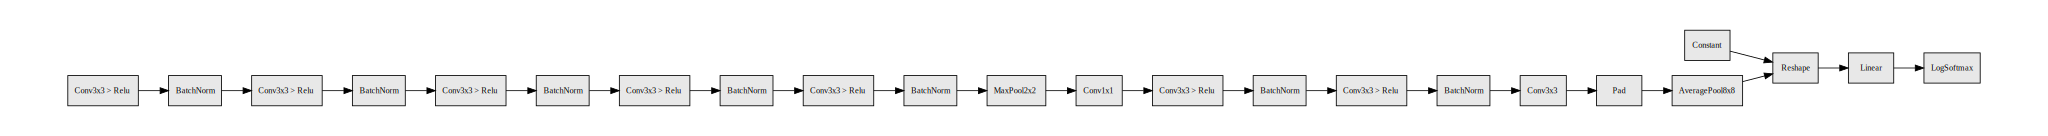

In [9]:
hl.build_graph(model, torch.zeros([1, 1, 28, 28]).to('cuda'))

In [16]:
network_graph = hl.build_graph(model, torch.zeros([1, 1, 28, 28]).to('cuda'))
network_graph.save("./images/network_1", "png")

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:680: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


### Network with Dropout

In [10]:
class DropoutNetwork(nn.Module):
    """Network with Dropout."""

    def __init__(self):
        super(DropoutNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)  # 28x28x1 -> 28x28x4
        self.bn1 = nn.BatchNorm2d(num_features=4)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=1)  # 28x28x4 -> 28x28x8
        self.bn2 = nn.BatchNorm2d(num_features=8)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3, padding=1)  # 28x28x8 -> 28x28x12
        self.bn3 = nn.BatchNorm2d(num_features=12)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, padding=1)  # 28x28x12 -> 28x28x16
        self.bn4 = nn.BatchNorm2d(num_features=16)
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=20, kernel_size=3, padding=1)  # 28x28x16 -> 28x28x20
        self.bn5 = nn.BatchNorm2d(num_features=20)
        self.dropout = nn.Dropout(0.069)

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 28x28x20 -> 14x14x20
        self.transition1 = nn.Conv2d(in_channels=20, out_channels=4, kernel_size=1)  # 14x14x20 -> 14x14x4

        self.conv6 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3)  # 14x14x4 -> 12x12x8
        self.bn6 = nn.BatchNorm2d(num_features=8)
        self.conv7 = nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3)  # 12x12x8 -> 10x10x12
        self.bn7 = nn.BatchNorm2d(num_features=12)
        self.conv8 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3)  # 10x10x12 -> 8x8x16

        self.gap = nn.AvgPool2d(kernel_size=8)
        self.fc1 = nn.Linear(in_features=16, out_features=10)

    def forward(self, net):
        net = self.dropout(F.relu(self.conv1(net)))
        net = self.bn2(F.relu(self.conv2(net)))
        net = self.bn3(F.relu(self.conv3(net)))
        net = self.bn4(F.relu(self.conv4(net)))
        net = self.bn5(F.relu(self.conv5(net)))
        net = self.transition1(self.pool1(net))
        net = self.bn6(F.relu(self.conv6(net)))
        net = self.bn7(F.relu(self.conv7(net)))
        net = self.conv8(net)
        net = self.gap(net)
        net = net.view(-1,16)
        net = self.fc1(net)

        return F.log_softmax(net, dim=1)

In [11]:
model = DropoutNetwork().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              40
           Dropout-2            [-1, 4, 28, 28]               0
            Conv2d-3            [-1, 8, 28, 28]             296
       BatchNorm2d-4            [-1, 8, 28, 28]              16
            Conv2d-5           [-1, 12, 28, 28]             876
       BatchNorm2d-6           [-1, 12, 28, 28]              24
            Conv2d-7           [-1, 16, 28, 28]           1,744
       BatchNorm2d-8           [-1, 16, 28, 28]              32
            Conv2d-9           [-1, 20, 28, 28]           2,900
      BatchNorm2d-10           [-1, 20, 28, 28]              40
        MaxPool2d-11           [-1, 20, 14, 14]               0
           Conv2d-12            [-1, 4, 14, 14]              84
           Conv2d-13            [-1, 8, 12, 12]             296
      BatchNorm2d-14            [-1, 8,

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:680: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")
/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:680: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


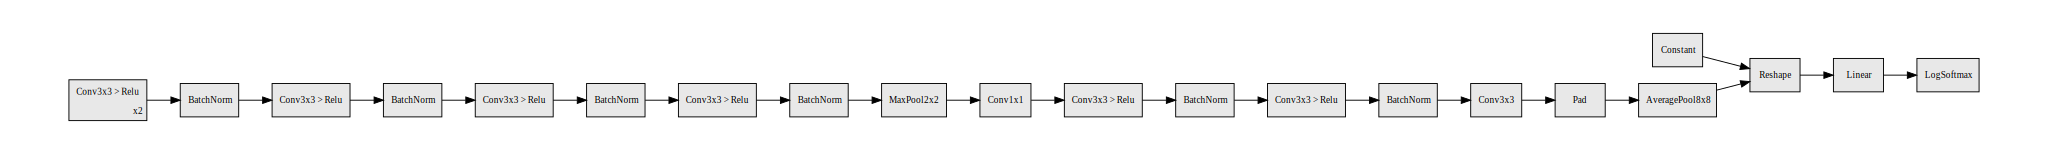

In [32]:
hl.build_graph(model, torch.zeros([1, 1, 28, 28]).to('cuda'))

In [34]:
network_graph = hl.build_graph(model, torch.zeros([1, 1, 28, 28]).to('cuda'))
network_graph.save("./images/network_4", "png")

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:680: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")
/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:680: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


### Network with Dropout and Transition layer before GAP

In [12]:
class DropoutTransitionNetwork(nn.Module):
    """Vanilla Network."""

    def __init__(self):
        super(DropoutTransitionNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)  # 28x28x1 -> 28x28x4
        self.bn1 = nn.BatchNorm2d(num_features=4)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=1)  # 28x28x4 -> 28x28x8
        self.bn2 = nn.BatchNorm2d(num_features=8)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3, padding=1)  # 28x28x8 -> 28x28x12
        self.bn3 = nn.BatchNorm2d(num_features=12)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, padding=1)  # 28x28x12 -> 28x28x16
        self.bn4 = nn.BatchNorm2d(num_features=16)
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=20, kernel_size=3, padding=1)  # 28x28x16 -> 28x28x20
        self.bn5 = nn.BatchNorm2d(num_features=20)
        self.dropout = nn.Dropout(0.069)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 28x28x20 -> 14x14x20
        self.transition1 = nn.Conv2d(in_channels=20, out_channels=4, kernel_size=1)  # 14x14x20 -> 14x14x4
        
        self.conv6 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3)  # 14x14x4 -> 12x12x8
        self.bn6 = nn.BatchNorm2d(num_features=8)
        self.conv7 = nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3)  # 12x12x8 -> 10x10x12
        self.bn7 = nn.BatchNorm2d(num_features=12)
        self.conv8 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3)  # 10x10x12 -> 8x8x16
        self.bn8 = nn.BatchNorm2d(num_features=16)
        self.conv9 = nn.Conv2d(in_channels=16, out_channels=10, kernel_size=1)
        
        self.gap = nn.AvgPool2d(kernel_size=8)
        self.fc1 = nn.Linear(in_features=10, out_features=10)

    def forward(self, net):
        net = self.dropout(F.relu(self.conv1(net)))
        net = self.bn2(F.relu(self.conv2(net)))
        net = self.bn3(F.relu(self.conv3(net)))
        net = self.bn4(F.relu(self.conv4(net)))
        net = self.bn5(F.relu(self.conv5(net)))
        net = self.transition1(self.pool1(net))
        net = self.bn6(F.relu(self.conv6(net)))
        net = self.bn7(F.relu(self.conv7(net)))
        net = self.conv9(self.bn8(F.relu(self.conv8(net))))
        net = self.gap(net)
        net = net.view(-1,10)
        net = self.fc1(net)

        return F.log_softmax(net, dim=1)

In [13]:
model = DropoutTransitionNetwork().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              40
           Dropout-2            [-1, 4, 28, 28]               0
            Conv2d-3            [-1, 8, 28, 28]             296
       BatchNorm2d-4            [-1, 8, 28, 28]              16
            Conv2d-5           [-1, 12, 28, 28]             876
       BatchNorm2d-6           [-1, 12, 28, 28]              24
            Conv2d-7           [-1, 16, 28, 28]           1,744
       BatchNorm2d-8           [-1, 16, 28, 28]              32
            Conv2d-9           [-1, 20, 28, 28]           2,900
      BatchNorm2d-10           [-1, 20, 28, 28]              40
        MaxPool2d-11           [-1, 20, 14, 14]               0
           Conv2d-12            [-1, 4, 14, 14]              84
           Conv2d-13            [-1, 8, 12, 12]             296
      BatchNorm2d-14            [-1, 8,

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:680: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")
/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:680: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


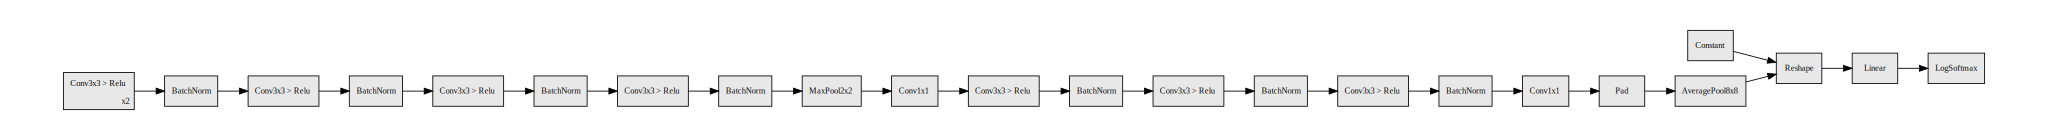

In [24]:
hl.build_graph(model, torch.zeros([1, 1, 28, 28]).to('cuda'))

In [26]:
network_graph = hl.build_graph(model, torch.zeros([1, 1, 28, 28]).to('cuda'))
network_graph.save("./images/network_2", "png")

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:680: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")
/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:680: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


### Network with Dropout and Transition layer before GAP and no FC

In [14]:
class DropoutTransitionNoFCNetwork(nn.Module):
    """Vanilla Network."""

    def __init__(self):
        super(DropoutTransitionNoFCNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)  # 28x28x1 -> 28x28x4
        self.bn1 = nn.BatchNorm2d(num_features=4)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=1)  # 28x28x4 -> 28x28x8
        self.bn2 = nn.BatchNorm2d(num_features=8)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3, padding=1)  # 28x28x8 -> 28x28x12
        self.bn3 = nn.BatchNorm2d(num_features=12)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, padding=1)  # 28x28x12 -> 28x28x16
        self.bn4 = nn.BatchNorm2d(num_features=16)
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=20, kernel_size=3, padding=1)  # 28x28x16 -> 28x28x20
        self.bn5 = nn.BatchNorm2d(num_features=20)
        self.dropout = nn.Dropout(0.069)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 28x28x20 -> 14x14x20
        self.transition1 = nn.Conv2d(in_channels=20, out_channels=4, kernel_size=1)  # 14x14x20 -> 14x14x4
        
        self.conv6 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3)  # 14x14x4 -> 12x12x8
        self.bn6 = nn.BatchNorm2d(num_features=8)
        self.conv7 = nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3)  # 12x12x8 -> 10x10x12
        self.bn7 = nn.BatchNorm2d(num_features=12)
        self.conv8 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3)  # 10x10x12 -> 8x8x16
        self.bn8 = nn.BatchNorm2d(num_features=16)
        self.conv9 = nn.Conv2d(in_channels=16, out_channels=10, kernel_size=1)
        
        self.gap = nn.AvgPool2d(kernel_size=8)
        self.fc1 = nn.Linear(in_features=10, out_features=10)

    def forward(self, net):
        net = self.dropout(F.relu(self.conv1(net)))
        net = self.bn2(F.relu(self.conv2(net)))
        net = self.bn3(F.relu(self.conv3(net)))
        net = self.bn4(F.relu(self.conv4(net)))
        net = self.bn5(F.relu(self.conv5(net)))
        net = self.transition1(self.pool1(net))
        net = self.bn6(F.relu(self.conv6(net)))
        net = self.bn7(F.relu(self.conv7(net)))
        net = self.conv9(self.bn8(F.relu(self.conv8(net))))
        net = self.gap(net)
        net = net.view(-1,10)

        return F.log_softmax(net, dim=1)

In [15]:
model = DropoutTransitionNoFCNetwork().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              40
           Dropout-2            [-1, 4, 28, 28]               0
            Conv2d-3            [-1, 8, 28, 28]             296
       BatchNorm2d-4            [-1, 8, 28, 28]              16
            Conv2d-5           [-1, 12, 28, 28]             876
       BatchNorm2d-6           [-1, 12, 28, 28]              24
            Conv2d-7           [-1, 16, 28, 28]           1,744
       BatchNorm2d-8           [-1, 16, 28, 28]              32
            Conv2d-9           [-1, 20, 28, 28]           2,900
      BatchNorm2d-10           [-1, 20, 28, 28]              40
        MaxPool2d-11           [-1, 20, 14, 14]               0
           Conv2d-12            [-1, 4, 14, 14]              84
           Conv2d-13            [-1, 8, 12, 12]             296
      BatchNorm2d-14            [-1, 8,

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:680: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")
/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:680: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


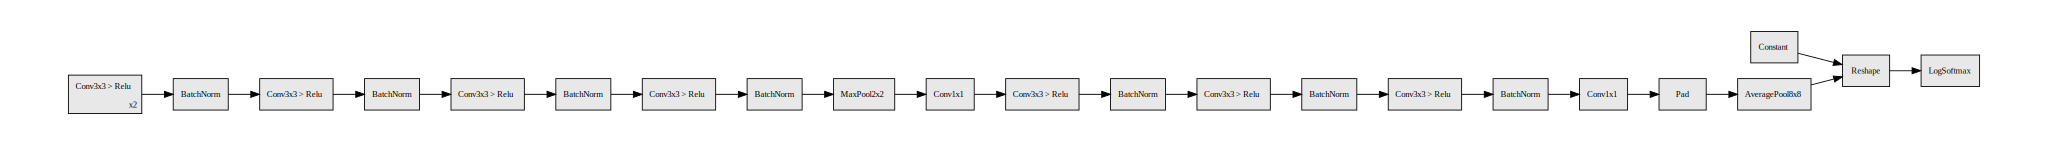

In [29]:
hl.build_graph(model, torch.zeros([1, 1, 28, 28]).to('cuda'))

In [30]:
network_graph = hl.build_graph(model, torch.zeros([1, 1, 28, 28]).to('cuda'))
network_graph.save("./images/network_3", "png")

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:680: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")
/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:680: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


## Download Dataset and perform augmentations

### Vanilla Dataset without any Data Augmentation

In [18]:
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))
test_data = datasets.MNIST(root='./data', train=False, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Dataset with Data Augmentation

In [19]:
train_data_with_augmentation = datasets.MNIST('./data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.RandomRotation(5),
                                    transforms.RandomAffine(degrees=8, translate=(0.15,0.15), scale=(0.85, 1.15)),
                                    transforms.ColorJitter(brightness=0.1, contrast=0.1),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))]))

## Creating DataLoaders: Batch size = 64
Downloading training data and testing data and creating Data loaders using the data

In [21]:
torch.manual_seed(1)
batch_size = 64

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [22]:
train_dataloader_vanilla = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, **kwargs)
train_dataloader_augmented = torch.utils.data.DataLoader(dataset=train_data_with_augmentation, batch_size=batch_size, shuffle=True, **kwargs)
test_dataloader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True, **kwargs)

## Training Models with Vanilla Dataset: Batch size = 64

### Constant Learning Rate

#### Training Vanilla Architecture

In [ ]:
model = Network().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_vanilla, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader)
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.3597, Train Accuracy: 88.00%;  Test set: Average loss: 0.0695, Test Accuracy: 97.84%
Epoch: 2



\Train set: Average loss: 0.0741, Train Accuracy: 97.79%;  Test set: Average loss: 0.0543, Test Accuracy: 98.41%
Epoch: 3



\Train set: Average loss: 0.0521, Train Accuracy: 98.44%;  Test set: Average loss: 0.0433, Test Accuracy: 98.68%
Epoch: 4



\Train set: Average loss: 0.0443, Train Accuracy: 98.65%;  Test set: Average loss: 0.0376, Test Accuracy: 98.80%
Epoch: 5



\Train set: Average loss: 0.0387, Train Accuracy: 98.75%;  Test set: Average loss: 0.0339, Test Accuracy: 98.98%
Epoch: 6



\Train set: Average loss: 0.0357, Train Accuracy: 98.89%;  Test set: Average loss: 0.0303, Test Accuracy: 99.03%
Epoch: 7



\Train set: Average loss: 0.0312, Train Accuracy: 99.02%;  Test set: Average loss: 0.0457, Test Accuracy: 98.58%
Epoch: 8



\Train set: Average loss: 0.0316, Train Accuracy: 99.01%;  Test set: Average loss: 0.0376, Test Accuracy: 98.81%
Epoch: 9



\Train set: Average loss: 0.0274, Train Accuracy: 99.13%;  Test set: Average loss: 0.0307, Test Accuracy: 98.98%
Epoch: 10



\Train set: Average loss: 0.0253, Train Accuracy: 99.21%;  Test set: Average loss: 0.0310, Test Accuracy: 99.03%
Epoch: 11



\Train set: Average loss: 0.0235, Train Accuracy: 99.26%;  Test set: Average loss: 0.0286, Test Accuracy: 98.99%
Epoch: 12



\Train set: Average loss: 0.0232, Train Accuracy: 99.22%;  Test set: Average loss: 0.0334, Test Accuracy: 98.99%
Epoch: 13



\Train set: Average loss: 0.0231, Train Accuracy: 99.22%;  Test set: Average loss: 0.0347, Test Accuracy: 98.99%
Epoch: 14



\Train set: Average loss: 0.0204, Train Accuracy: 99.33%;  Test set: Average loss: 0.0352, Test Accuracy: 98.98%
Epoch: 15



\Train set: Average loss: 0.0201, Train Accuracy: 99.31%;  Test set: Average loss: 0.0312, Test Accuracy: 99.04%
Epoch: 16



\Train set: Average loss: 0.0183, Train Accuracy: 99.41%;  Test set: Average loss: 0.0272, Test Accuracy: 99.15%
Epoch: 17



\Train set: Average loss: 0.0195, Train Accuracy: 99.34%;  Test set: Average loss: 0.0294, Test Accuracy: 99.08%
Epoch: 18



\Train set: Average loss: 0.0194, Train Accuracy: 99.37%;  Test set: Average loss: 0.0330, Test Accuracy: 98.96%
Epoch: 19



\Train set: Average loss: 0.0170, Train Accuracy: 99.45%;  Test set: Average loss: 0.0290, Test Accuracy: 99.00%


#### Training Dropout Architecture

In [ ]:
model = DropoutNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_vanilla, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader)
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.3703, Train Accuracy: 88.13%;  Test set: Average loss: 0.1073, Test Accuracy: 96.61%
Epoch: 2



\Train set: Average loss: 0.0917, Train Accuracy: 97.14%;  Test set: Average loss: 0.0593, Test Accuracy: 98.17%
Epoch: 3



\Train set: Average loss: 0.0716, Train Accuracy: 97.80%;  Test set: Average loss: 0.0870, Test Accuracy: 97.20%
Epoch: 4



\Train set: Average loss: 0.0607, Train Accuracy: 98.15%;  Test set: Average loss: 0.0451, Test Accuracy: 98.64%
Epoch: 5



\Train set: Average loss: 0.0526, Train Accuracy: 98.40%;  Test set: Average loss: 0.0376, Test Accuracy: 98.75%
Epoch: 6



\Train set: Average loss: 0.0481, Train Accuracy: 98.50%;  Test set: Average loss: 0.0378, Test Accuracy: 98.85%
Epoch: 7



\Train set: Average loss: 0.0432, Train Accuracy: 98.64%;  Test set: Average loss: 0.0389, Test Accuracy: 98.79%
Epoch: 8



\Train set: Average loss: 0.0408, Train Accuracy: 98.72%;  Test set: Average loss: 0.0318, Test Accuracy: 98.98%
Epoch: 9



\Train set: Average loss: 0.0383, Train Accuracy: 98.79%;  Test set: Average loss: 0.0363, Test Accuracy: 98.87%
Epoch: 10



\Train set: Average loss: 0.0362, Train Accuracy: 98.87%;  Test set: Average loss: 0.0296, Test Accuracy: 99.00%
Epoch: 11



\Train set: Average loss: 0.0321, Train Accuracy: 98.99%;  Test set: Average loss: 0.0290, Test Accuracy: 99.13%
Epoch: 12



\Train set: Average loss: 0.0335, Train Accuracy: 98.94%;  Test set: Average loss: 0.0305, Test Accuracy: 98.96%
Epoch: 13



\Train set: Average loss: 0.0308, Train Accuracy: 99.01%;  Test set: Average loss: 0.0322, Test Accuracy: 98.83%
Epoch: 14



\Train set: Average loss: 0.0295, Train Accuracy: 99.04%;  Test set: Average loss: 0.0329, Test Accuracy: 98.91%
Epoch: 15



\Train set: Average loss: 0.0282, Train Accuracy: 99.11%;  Test set: Average loss: 0.0266, Test Accuracy: 99.14%
Epoch: 16



\Train set: Average loss: 0.0270, Train Accuracy: 99.10%;  Test set: Average loss: 0.0296, Test Accuracy: 98.93%
Epoch: 17



\Train set: Average loss: 0.0266, Train Accuracy: 99.15%;  Test set: Average loss: 0.0283, Test Accuracy: 99.03%
Epoch: 18



\Train set: Average loss: 0.0259, Train Accuracy: 99.12%;  Test set: Average loss: 0.0292, Test Accuracy: 99.04%
Epoch: 19



\Train set: Average loss: 0.0234, Train Accuracy: 99.25%;  Test set: Average loss: 0.0303, Test Accuracy: 99.00%


#### Training Dropout Transition Network

In [ ]:
model = DropoutTransitionNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_vanilla, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader)
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.4554, Train Accuracy: 85.25%;  Test set: Average loss: 0.1140, Test Accuracy: 96.46%
Epoch: 2



\Train set: Average loss: 0.0887, Train Accuracy: 97.37%;  Test set: Average loss: 0.0594, Test Accuracy: 98.02%
Epoch: 3



\Train set: Average loss: 0.0656, Train Accuracy: 98.00%;  Test set: Average loss: 0.0437, Test Accuracy: 98.60%
Epoch: 4



\Train set: Average loss: 0.0557, Train Accuracy: 98.28%;  Test set: Average loss: 0.0355, Test Accuracy: 98.81%
Epoch: 5



\Train set: Average loss: 0.0488, Train Accuracy: 98.52%;  Test set: Average loss: 0.0369, Test Accuracy: 98.93%
Epoch: 6



\Train set: Average loss: 0.0447, Train Accuracy: 98.58%;  Test set: Average loss: 0.0280, Test Accuracy: 99.08%
Epoch: 7



\Train set: Average loss: 0.0401, Train Accuracy: 98.78%;  Test set: Average loss: 0.0262, Test Accuracy: 99.12%
Epoch: 8



\Train set: Average loss: 0.0362, Train Accuracy: 98.84%;  Test set: Average loss: 0.0426, Test Accuracy: 98.63%
Epoch: 9



\Train set: Average loss: 0.0331, Train Accuracy: 98.97%;  Test set: Average loss: 0.0276, Test Accuracy: 99.10%
Epoch: 10



\Train set: Average loss: 0.0321, Train Accuracy: 98.99%;  Test set: Average loss: 0.0289, Test Accuracy: 99.11%
Epoch: 11



\Train set: Average loss: 0.0318, Train Accuracy: 98.99%;  Test set: Average loss: 0.0276, Test Accuracy: 99.11%
Epoch: 12



\Train set: Average loss: 0.0306, Train Accuracy: 99.08%;  Test set: Average loss: 0.0252, Test Accuracy: 99.27%
Epoch: 13



\Train set: Average loss: 0.0275, Train Accuracy: 99.17%;  Test set: Average loss: 0.0249, Test Accuracy: 99.28%
Epoch: 14



\Train set: Average loss: 0.0276, Train Accuracy: 99.09%;  Test set: Average loss: 0.0296, Test Accuracy: 99.00%
Epoch: 15



\Train set: Average loss: 0.0258, Train Accuracy: 99.18%;  Test set: Average loss: 0.0246, Test Accuracy: 99.16%
Epoch: 16



\Train set: Average loss: 0.0242, Train Accuracy: 99.22%;  Test set: Average loss: 0.0257, Test Accuracy: 99.24%
Epoch: 17



\Train set: Average loss: 0.0244, Train Accuracy: 99.22%;  Test set: Average loss: 0.0251, Test Accuracy: 99.16%
Epoch: 18



\Train set: Average loss: 0.0234, Train Accuracy: 99.25%;  Test set: Average loss: 0.0271, Test Accuracy: 99.05%
Epoch: 19



\Train set: Average loss: 0.0224, Train Accuracy: 99.27%;  Test set: Average loss: 0.0231, Test Accuracy: 99.20%


#### Training Dropout Transition No FC Network

In [ ]:
model = DropoutTransitionNoFCNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_vanilla, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader)
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.3600, Train Accuracy: 89.91%;  Test set: Average loss: 0.1194, Test Accuracy: 96.51%
Epoch: 2



\Train set: Average loss: 0.0790, Train Accuracy: 97.72%;  Test set: Average loss: 0.0464, Test Accuracy: 98.71%
Epoch: 3



\Train set: Average loss: 0.0614, Train Accuracy: 98.15%;  Test set: Average loss: 0.0384, Test Accuracy: 98.91%
Epoch: 4



\Train set: Average loss: 0.0504, Train Accuracy: 98.50%;  Test set: Average loss: 0.0415, Test Accuracy: 98.76%
Epoch: 5



\Train set: Average loss: 0.0442, Train Accuracy: 98.70%;  Test set: Average loss: 0.0418, Test Accuracy: 98.77%
Epoch: 6



\Train set: Average loss: 0.0413, Train Accuracy: 98.70%;  Test set: Average loss: 0.0281, Test Accuracy: 99.16%
Epoch: 7



\Train set: Average loss: 0.0375, Train Accuracy: 98.86%;  Test set: Average loss: 0.0270, Test Accuracy: 99.14%
Epoch: 8



\Train set: Average loss: 0.0338, Train Accuracy: 98.98%;  Test set: Average loss: 0.0282, Test Accuracy: 99.12%
Epoch: 9



\Train set: Average loss: 0.0336, Train Accuracy: 99.00%;  Test set: Average loss: 0.0279, Test Accuracy: 99.18%
Epoch: 10



\Train set: Average loss: 0.0296, Train Accuracy: 99.09%;  Test set: Average loss: 0.0250, Test Accuracy: 99.22%
Epoch: 11



\Train set: Average loss: 0.0293, Train Accuracy: 99.10%;  Test set: Average loss: 0.0252, Test Accuracy: 99.15%
Epoch: 12



\Train set: Average loss: 0.0272, Train Accuracy: 99.13%;  Test set: Average loss: 0.0262, Test Accuracy: 99.21%
Epoch: 13



\Train set: Average loss: 0.0261, Train Accuracy: 99.17%;  Test set: Average loss: 0.0280, Test Accuracy: 99.10%
Epoch: 14



\Train set: Average loss: 0.0252, Train Accuracy: 99.25%;  Test set: Average loss: 0.0234, Test Accuracy: 99.26%
Epoch: 15



\Train set: Average loss: 0.0235, Train Accuracy: 99.27%;  Test set: Average loss: 0.0241, Test Accuracy: 99.24%
Epoch: 16



\Train set: Average loss: 0.0235, Train Accuracy: 99.27%;  Test set: Average loss: 0.0247, Test Accuracy: 99.24%
Epoch: 17



\Train set: Average loss: 0.0227, Train Accuracy: 99.28%;  Test set: Average loss: 0.0245, Test Accuracy: 99.24%
Epoch: 18



\Train set: Average loss: 0.0224, Train Accuracy: 99.28%;  Test set: Average loss: 0.0216, Test Accuracy: 99.34%
Epoch: 19



\Train set: Average loss: 0.0202, Train Accuracy: 99.39%;  Test set: Average loss: 0.0277, Test Accuracy: 99.22%


### Introducing Step Learning Rate

#### Training Vanilla Architecture

In [ ]:
model = Network().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size= 8, gamma= 0.25)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_vanilla, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader)
    scheduler.step()
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.3494, Train Accuracy: 88.68%;  Test set: Average loss: 0.1350, Test Accuracy: 95.68%
Epoch: 2



\Train set: Average loss: 0.0813, Train Accuracy: 97.53%;  Test set: Average loss: 0.0933, Test Accuracy: 97.02%
Epoch: 3



\Train set: Average loss: 0.0629, Train Accuracy: 98.10%;  Test set: Average loss: 0.0475, Test Accuracy: 98.63%
Epoch: 4



\Train set: Average loss: 0.0518, Train Accuracy: 98.41%;  Test set: Average loss: 0.0563, Test Accuracy: 98.25%
Epoch: 5



\Train set: Average loss: 0.0462, Train Accuracy: 98.55%;  Test set: Average loss: 0.0383, Test Accuracy: 98.74%
Epoch: 6



\Train set: Average loss: 0.0409, Train Accuracy: 98.70%;  Test set: Average loss: 0.0385, Test Accuracy: 98.86%
Epoch: 7



\Train set: Average loss: 0.0383, Train Accuracy: 98.85%;  Test set: Average loss: 0.0410, Test Accuracy: 98.68%
Epoch: 8



\Train set: Average loss: 0.0341, Train Accuracy: 98.95%;  Test set: Average loss: 0.0345, Test Accuracy: 98.88%
Epoch: 9



\Train set: Average loss: 0.0228, Train Accuracy: 99.28%;  Test set: Average loss: 0.0256, Test Accuracy: 99.22%
Epoch: 10



\Train set: Average loss: 0.0202, Train Accuracy: 99.38%;  Test set: Average loss: 0.0252, Test Accuracy: 99.12%
Epoch: 11



\Train set: Average loss: 0.0196, Train Accuracy: 99.40%;  Test set: Average loss: 0.0272, Test Accuracy: 99.15%
Epoch: 12



\Train set: Average loss: 0.0188, Train Accuracy: 99.42%;  Test set: Average loss: 0.0286, Test Accuracy: 99.09%
Epoch: 13



\Train set: Average loss: 0.0176, Train Accuracy: 99.47%;  Test set: Average loss: 0.0259, Test Accuracy: 99.22%
Epoch: 14



\Train set: Average loss: 0.0172, Train Accuracy: 99.47%;  Test set: Average loss: 0.0272, Test Accuracy: 99.19%
Epoch: 15



\Train set: Average loss: 0.0160, Train Accuracy: 99.54%;  Test set: Average loss: 0.0262, Test Accuracy: 99.19%
Epoch: 16



\Train set: Average loss: 0.0156, Train Accuracy: 99.51%;  Test set: Average loss: 0.0267, Test Accuracy: 99.20%
Epoch: 17



\Train set: Average loss: 0.0132, Train Accuracy: 99.62%;  Test set: Average loss: 0.0248, Test Accuracy: 99.25%
Epoch: 18



\Train set: Average loss: 0.0122, Train Accuracy: 99.65%;  Test set: Average loss: 0.0247, Test Accuracy: 99.27%
Epoch: 19



\Train set: Average loss: 0.0121, Train Accuracy: 99.66%;  Test set: Average loss: 0.0251, Test Accuracy: 99.25%


#### Training Dropout Architecture

In [ ]:
model = DropoutNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size= 8, gamma= 0.25)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_vanilla, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader)
    scheduler.step()
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.3644, Train Accuracy: 88.34%;  Test set: Average loss: 0.1042, Test Accuracy: 96.98%
Epoch: 2



\Train set: Average loss: 0.0760, Train Accuracy: 97.73%;  Test set: Average loss: 0.0610, Test Accuracy: 98.15%
Epoch: 3



\Train set: Average loss: 0.0578, Train Accuracy: 98.24%;  Test set: Average loss: 0.0412, Test Accuracy: 98.69%
Epoch: 4



\Train set: Average loss: 0.0495, Train Accuracy: 98.48%;  Test set: Average loss: 0.0396, Test Accuracy: 98.78%
Epoch: 5



\Train set: Average loss: 0.0457, Train Accuracy: 98.58%;  Test set: Average loss: 0.0340, Test Accuracy: 98.79%
Epoch: 6



\Train set: Average loss: 0.0398, Train Accuracy: 98.73%;  Test set: Average loss: 0.0435, Test Accuracy: 98.60%
Epoch: 7



\Train set: Average loss: 0.0376, Train Accuracy: 98.82%;  Test set: Average loss: 0.0363, Test Accuracy: 98.85%
Epoch: 8



\Train set: Average loss: 0.0356, Train Accuracy: 98.85%;  Test set: Average loss: 0.0322, Test Accuracy: 98.93%
Epoch: 9



\Train set: Average loss: 0.0246, Train Accuracy: 99.29%;  Test set: Average loss: 0.0265, Test Accuracy: 99.09%
Epoch: 10



\Train set: Average loss: 0.0232, Train Accuracy: 99.30%;  Test set: Average loss: 0.0257, Test Accuracy: 99.10%
Epoch: 11



\Train set: Average loss: 0.0228, Train Accuracy: 99.28%;  Test set: Average loss: 0.0265, Test Accuracy: 99.10%
Epoch: 12



\Train set: Average loss: 0.0214, Train Accuracy: 99.33%;  Test set: Average loss: 0.0269, Test Accuracy: 99.18%
Epoch: 13



\Train set: Average loss: 0.0213, Train Accuracy: 99.36%;  Test set: Average loss: 0.0269, Test Accuracy: 99.12%
Epoch: 14



\Train set: Average loss: 0.0204, Train Accuracy: 99.40%;  Test set: Average loss: 0.0271, Test Accuracy: 99.09%
Epoch: 15



\Train set: Average loss: 0.0200, Train Accuracy: 99.39%;  Test set: Average loss: 0.0261, Test Accuracy: 99.18%
Epoch: 16



\Train set: Average loss: 0.0198, Train Accuracy: 99.37%;  Test set: Average loss: 0.0283, Test Accuracy: 99.03%
Epoch: 17



\Train set: Average loss: 0.0169, Train Accuracy: 99.51%;  Test set: Average loss: 0.0245, Test Accuracy: 99.15%
Epoch: 18



\Train set: Average loss: 0.0171, Train Accuracy: 99.47%;  Test set: Average loss: 0.0253, Test Accuracy: 99.18%
Epoch: 19



\Train set: Average loss: 0.0170, Train Accuracy: 99.45%;  Test set: Average loss: 0.0251, Test Accuracy: 99.18%


#### Training Dropout Transition Network

In [ ]:
model = DropoutTransitionNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size= 8, gamma= 0.25)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_vanilla, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader)
    scheduler.step()
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.4726, Train Accuracy: 84.59%;  Test set: Average loss: 0.0942, Test Accuracy: 97.37%
Epoch: 2



\Train set: Average loss: 0.1013, Train Accuracy: 97.08%;  Test set: Average loss: 0.1015, Test Accuracy: 97.05%
Epoch: 3



\Train set: Average loss: 0.0741, Train Accuracy: 97.86%;  Test set: Average loss: 0.0487, Test Accuracy: 98.65%
Epoch: 4



\Train set: Average loss: 0.0577, Train Accuracy: 98.28%;  Test set: Average loss: 0.0503, Test Accuracy: 98.43%
Epoch: 5



\Train set: Average loss: 0.0486, Train Accuracy: 98.54%;  Test set: Average loss: 0.0403, Test Accuracy: 98.88%
Epoch: 6



\Train set: Average loss: 0.0441, Train Accuracy: 98.63%;  Test set: Average loss: 0.0393, Test Accuracy: 98.78%
Epoch: 7



\Train set: Average loss: 0.0385, Train Accuracy: 98.83%;  Test set: Average loss: 0.0361, Test Accuracy: 98.83%
Epoch: 8



\Train set: Average loss: 0.0374, Train Accuracy: 98.83%;  Test set: Average loss: 0.0388, Test Accuracy: 98.83%
Epoch: 9



\Train set: Average loss: 0.0263, Train Accuracy: 99.18%;  Test set: Average loss: 0.0250, Test Accuracy: 99.30%
Epoch: 10



\Train set: Average loss: 0.0238, Train Accuracy: 99.29%;  Test set: Average loss: 0.0253, Test Accuracy: 99.28%
Epoch: 11



\Train set: Average loss: 0.0229, Train Accuracy: 99.29%;  Test set: Average loss: 0.0236, Test Accuracy: 99.28%
Epoch: 12



\Train set: Average loss: 0.0218, Train Accuracy: 99.30%;  Test set: Average loss: 0.0230, Test Accuracy: 99.29%
Epoch: 13



\Train set: Average loss: 0.0220, Train Accuracy: 99.32%;  Test set: Average loss: 0.0227, Test Accuracy: 99.30%
Epoch: 14



\Train set: Average loss: 0.0206, Train Accuracy: 99.35%;  Test set: Average loss: 0.0233, Test Accuracy: 99.25%
Epoch: 15



\Train set: Average loss: 0.0204, Train Accuracy: 99.35%;  Test set: Average loss: 0.0239, Test Accuracy: 99.25%
Epoch: 16



\Train set: Average loss: 0.0199, Train Accuracy: 99.33%;  Test set: Average loss: 0.0259, Test Accuracy: 99.18%
Epoch: 17



\Train set: Average loss: 0.0174, Train Accuracy: 99.46%;  Test set: Average loss: 0.0230, Test Accuracy: 99.30%
Epoch: 18



\Train set: Average loss: 0.0173, Train Accuracy: 99.47%;  Test set: Average loss: 0.0234, Test Accuracy: 99.30%
Epoch: 19



\Train set: Average loss: 0.0172, Train Accuracy: 99.46%;  Test set: Average loss: 0.0232, Test Accuracy: 99.29%


#### Training Dropout Transition No FC Network

In [ ]:
model = DropoutTransitionNoFCNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size= 8, gamma= 0.25)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_vanilla, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader)
    scheduler.step()
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.3480, Train Accuracy: 91.03%;  Test set: Average loss: 0.1546, Test Accuracy: 95.32%
Epoch: 2



\Train set: Average loss: 0.0805, Train Accuracy: 97.67%;  Test set: Average loss: 0.0536, Test Accuracy: 98.26%
Epoch: 3



\Train set: Average loss: 0.0609, Train Accuracy: 98.22%;  Test set: Average loss: 0.0473, Test Accuracy: 98.53%
Epoch: 4



\Train set: Average loss: 0.0516, Train Accuracy: 98.46%;  Test set: Average loss: 0.0397, Test Accuracy: 98.77%
Epoch: 5



\Train set: Average loss: 0.0449, Train Accuracy: 98.66%;  Test set: Average loss: 0.0374, Test Accuracy: 98.85%
Epoch: 6



\Train set: Average loss: 0.0415, Train Accuracy: 98.78%;  Test set: Average loss: 0.0329, Test Accuracy: 98.92%
Epoch: 7



\Train set: Average loss: 0.0372, Train Accuracy: 98.88%;  Test set: Average loss: 0.0377, Test Accuracy: 98.74%
Epoch: 8



\Train set: Average loss: 0.0353, Train Accuracy: 98.90%;  Test set: Average loss: 0.0324, Test Accuracy: 99.07%
Epoch: 9



\Train set: Average loss: 0.0261, Train Accuracy: 99.20%;  Test set: Average loss: 0.0238, Test Accuracy: 99.28%
Epoch: 10



\Train set: Average loss: 0.0238, Train Accuracy: 99.30%;  Test set: Average loss: 0.0222, Test Accuracy: 99.24%
Epoch: 11



\Train set: Average loss: 0.0224, Train Accuracy: 99.33%;  Test set: Average loss: 0.0229, Test Accuracy: 99.24%
Epoch: 12



\Train set: Average loss: 0.0221, Train Accuracy: 99.36%;  Test set: Average loss: 0.0229, Test Accuracy: 99.18%
Epoch: 13



\Train set: Average loss: 0.0221, Train Accuracy: 99.32%;  Test set: Average loss: 0.0224, Test Accuracy: 99.21%
Epoch: 14



\Train set: Average loss: 0.0212, Train Accuracy: 99.34%;  Test set: Average loss: 0.0237, Test Accuracy: 99.18%
Epoch: 15



\Train set: Average loss: 0.0204, Train Accuracy: 99.39%;  Test set: Average loss: 0.0233, Test Accuracy: 99.22%
Epoch: 16



\Train set: Average loss: 0.0200, Train Accuracy: 99.39%;  Test set: Average loss: 0.0228, Test Accuracy: 99.26%
Epoch: 17



\Train set: Average loss: 0.0182, Train Accuracy: 99.46%;  Test set: Average loss: 0.0219, Test Accuracy: 99.28%
Epoch: 18



\Train set: Average loss: 0.0173, Train Accuracy: 99.51%;  Test set: Average loss: 0.0211, Test Accuracy: 99.35%
Epoch: 19



\Train set: Average loss: 0.0172, Train Accuracy: 99.50%;  Test set: Average loss: 0.0216, Test Accuracy: 99.26%


### Introducing Reduce Learning Rate on Plateau

#### Training Vanilla Architecture

In [ ]:
model = Network().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.1, patience=1, threshold=0.2, threshold_mode='abs', verbose=True)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_vanilla, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader)
    scheduler.step(test_acc)
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.3641, Train Accuracy: 87.91%;  Test set: Average loss: 0.1341, Test Accuracy: 95.82%
Epoch: 2



\Train set: Average loss: 0.0798, Train Accuracy: 97.55%;  Test set: Average loss: 0.0581, Test Accuracy: 98.31%
Epoch: 3



\Train set: Average loss: 0.0612, Train Accuracy: 98.13%;  Test set: Average loss: 0.0774, Test Accuracy: 97.62%
Epoch: 4



Epoch     4: reducing learning rate of group 0 to 1.0000e-03.
\Train set: Average loss: 0.0511, Train Accuracy: 98.40%;  Test set: Average loss: 0.0479, Test Accuracy: 98.47%
Epoch: 5



\Train set: Average loss: 0.0327, Train Accuracy: 99.00%;  Test set: Average loss: 0.0316, Test Accuracy: 99.04%
Epoch: 6



\Train set: Average loss: 0.0293, Train Accuracy: 99.12%;  Test set: Average loss: 0.0308, Test Accuracy: 99.02%
Epoch: 7



Epoch     7: reducing learning rate of group 0 to 1.0000e-04.
\Train set: Average loss: 0.0287, Train Accuracy: 99.11%;  Test set: Average loss: 0.0290, Test Accuracy: 99.10%
Epoch: 8



\Train set: Average loss: 0.0263, Train Accuracy: 99.21%;  Test set: Average loss: 0.0288, Test Accuracy: 99.09%
Epoch: 9



Epoch     9: reducing learning rate of group 0 to 1.0000e-05.
\Train set: Average loss: 0.0257, Train Accuracy: 99.23%;  Test set: Average loss: 0.0296, Test Accuracy: 99.09%
Epoch: 10



\Train set: Average loss: 0.0251, Train Accuracy: 99.28%;  Test set: Average loss: 0.0283, Test Accuracy: 99.12%
Epoch: 11



Epoch    11: reducing learning rate of group 0 to 1.0000e-06.
\Train set: Average loss: 0.0258, Train Accuracy: 99.25%;  Test set: Average loss: 0.0284, Test Accuracy: 99.11%
Epoch: 12



\Train set: Average loss: 0.0256, Train Accuracy: 99.24%;  Test set: Average loss: 0.0290, Test Accuracy: 99.11%
Epoch: 13



Epoch    13: reducing learning rate of group 0 to 1.0000e-07.
\Train set: Average loss: 0.0258, Train Accuracy: 99.22%;  Test set: Average loss: 0.0285, Test Accuracy: 99.09%
Epoch: 14



\Train set: Average loss: 0.0263, Train Accuracy: 99.23%;  Test set: Average loss: 0.0291, Test Accuracy: 99.11%
Epoch: 15



Epoch    15: reducing learning rate of group 0 to 1.0000e-08.
\Train set: Average loss: 0.0251, Train Accuracy: 99.27%;  Test set: Average loss: 0.0290, Test Accuracy: 99.11%
Epoch: 16



\Train set: Average loss: 0.0258, Train Accuracy: 99.22%;  Test set: Average loss: 0.0281, Test Accuracy: 99.12%
Epoch: 17



\Train set: Average loss: 0.0256, Train Accuracy: 99.20%;  Test set: Average loss: 0.0283, Test Accuracy: 99.11%
Epoch: 18



\Train set: Average loss: 0.0260, Train Accuracy: 99.24%;  Test set: Average loss: 0.0297, Test Accuracy: 99.12%
Epoch: 19



\Train set: Average loss: 0.0256, Train Accuracy: 99.21%;  Test set: Average loss: 0.0290, Test Accuracy: 99.11%


#### Training Dropout Architecture

In [ ]:
model = DropoutNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.1, patience=1, threshold=0.2, threshold_mode='abs', verbose=True)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_vanilla, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader)
    scheduler.step(test_acc)
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.3627, Train Accuracy: 87.81%;  Test set: Average loss: 0.0815, Test Accuracy: 97.59%
Epoch: 2



\Train set: Average loss: 0.0830, Train Accuracy: 97.43%;  Test set: Average loss: 0.0695, Test Accuracy: 97.90%
Epoch: 3



\Train set: Average loss: 0.0653, Train Accuracy: 98.01%;  Test set: Average loss: 0.0435, Test Accuracy: 98.71%
Epoch: 4



\Train set: Average loss: 0.0551, Train Accuracy: 98.30%;  Test set: Average loss: 0.0419, Test Accuracy: 98.60%
Epoch: 5



Epoch     5: reducing learning rate of group 0 to 1.0000e-03.
\Train set: Average loss: 0.0510, Train Accuracy: 98.39%;  Test set: Average loss: 0.0395, Test Accuracy: 98.87%
Epoch: 6



\Train set: Average loss: 0.0338, Train Accuracy: 98.96%;  Test set: Average loss: 0.0267, Test Accuracy: 99.22%
Epoch: 7



\Train set: Average loss: 0.0317, Train Accuracy: 99.05%;  Test set: Average loss: 0.0265, Test Accuracy: 99.26%
Epoch: 8



Epoch     8: reducing learning rate of group 0 to 1.0000e-04.
\Train set: Average loss: 0.0305, Train Accuracy: 99.06%;  Test set: Average loss: 0.0259, Test Accuracy: 99.24%
Epoch: 9



\Train set: Average loss: 0.0292, Train Accuracy: 99.16%;  Test set: Average loss: 0.0264, Test Accuracy: 99.25%
Epoch: 10



Epoch    10: reducing learning rate of group 0 to 1.0000e-05.
\Train set: Average loss: 0.0284, Train Accuracy: 99.15%;  Test set: Average loss: 0.0258, Test Accuracy: 99.26%
Epoch: 11



\Train set: Average loss: 0.0290, Train Accuracy: 99.17%;  Test set: Average loss: 0.0255, Test Accuracy: 99.29%
Epoch: 12



Epoch    12: reducing learning rate of group 0 to 1.0000e-06.
\Train set: Average loss: 0.0284, Train Accuracy: 99.15%;  Test set: Average loss: 0.0260, Test Accuracy: 99.26%
Epoch: 13



\Train set: Average loss: 0.0281, Train Accuracy: 99.15%;  Test set: Average loss: 0.0253, Test Accuracy: 99.24%
Epoch: 14



Epoch    14: reducing learning rate of group 0 to 1.0000e-07.
\Train set: Average loss: 0.0285, Train Accuracy: 99.10%;  Test set: Average loss: 0.0248, Test Accuracy: 99.30%
Epoch: 15



\Train set: Average loss: 0.0283, Train Accuracy: 99.16%;  Test set: Average loss: 0.0249, Test Accuracy: 99.28%
Epoch: 16



Epoch    16: reducing learning rate of group 0 to 1.0000e-08.
\Train set: Average loss: 0.0281, Train Accuracy: 99.14%;  Test set: Average loss: 0.0253, Test Accuracy: 99.27%
Epoch: 17



\Train set: Average loss: 0.0282, Train Accuracy: 99.17%;  Test set: Average loss: 0.0257, Test Accuracy: 99.23%
Epoch: 18



\Train set: Average loss: 0.0289, Train Accuracy: 99.14%;  Test set: Average loss: 0.0258, Test Accuracy: 99.22%
Epoch: 19



\Train set: Average loss: 0.0281, Train Accuracy: 99.19%;  Test set: Average loss: 0.0254, Test Accuracy: 99.25%


#### Training Dropout Transition Network

In [ ]:
model = DropoutTransitionNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.1, patience=1, threshold=0.2, threshold_mode='abs', verbose=True)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_vanilla, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader)
    scheduler.step(test_acc)
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.4440, Train Accuracy: 85.91%;  Test set: Average loss: 0.1738, Test Accuracy: 95.08%
Epoch: 2



\Train set: Average loss: 0.1026, Train Accuracy: 97.07%;  Test set: Average loss: 0.0739, Test Accuracy: 97.85%
Epoch: 3



\Train set: Average loss: 0.0718, Train Accuracy: 97.91%;  Test set: Average loss: 0.0500, Test Accuracy: 98.44%
Epoch: 4



\Train set: Average loss: 0.0562, Train Accuracy: 98.34%;  Test set: Average loss: 0.0479, Test Accuracy: 98.53%
Epoch: 5



\Train set: Average loss: 0.0512, Train Accuracy: 98.47%;  Test set: Average loss: 0.0406, Test Accuracy: 98.72%
Epoch: 6



\Train set: Average loss: 0.0435, Train Accuracy: 98.67%;  Test set: Average loss: 0.0371, Test Accuracy: 98.89%
Epoch: 7



\Train set: Average loss: 0.0396, Train Accuracy: 98.77%;  Test set: Average loss: 0.0280, Test Accuracy: 99.10%
Epoch: 8



\Train set: Average loss: 0.0367, Train Accuracy: 98.84%;  Test set: Average loss: 0.0335, Test Accuracy: 98.87%
Epoch: 9



Epoch     9: reducing learning rate of group 0 to 1.0000e-03.
\Train set: Average loss: 0.0346, Train Accuracy: 98.92%;  Test set: Average loss: 0.0298, Test Accuracy: 98.94%
Epoch: 10



\Train set: Average loss: 0.0241, Train Accuracy: 99.26%;  Test set: Average loss: 0.0189, Test Accuracy: 99.39%
Epoch: 11



\Train set: Average loss: 0.0222, Train Accuracy: 99.28%;  Test set: Average loss: 0.0190, Test Accuracy: 99.39%
Epoch: 12



Epoch    12: reducing learning rate of group 0 to 1.0000e-04.
\Train set: Average loss: 0.0208, Train Accuracy: 99.35%;  Test set: Average loss: 0.0186, Test Accuracy: 99.37%
Epoch: 13



\Train set: Average loss: 0.0190, Train Accuracy: 99.44%;  Test set: Average loss: 0.0185, Test Accuracy: 99.38%
Epoch: 14



Epoch    14: reducing learning rate of group 0 to 1.0000e-05.
\Train set: Average loss: 0.0194, Train Accuracy: 99.40%;  Test set: Average loss: 0.0189, Test Accuracy: 99.39%
Epoch: 15



\Train set: Average loss: 0.0195, Train Accuracy: 99.40%;  Test set: Average loss: 0.0190, Test Accuracy: 99.33%
Epoch: 16



Epoch    16: reducing learning rate of group 0 to 1.0000e-06.
\Train set: Average loss: 0.0195, Train Accuracy: 99.39%;  Test set: Average loss: 0.0181, Test Accuracy: 99.42%
Epoch: 17



\Train set: Average loss: 0.0195, Train Accuracy: 99.39%;  Test set: Average loss: 0.0186, Test Accuracy: 99.39%
Epoch: 18



Epoch    18: reducing learning rate of group 0 to 1.0000e-07.
\Train set: Average loss: 0.0201, Train Accuracy: 99.40%;  Test set: Average loss: 0.0188, Test Accuracy: 99.37%
Epoch: 19



\Train set: Average loss: 0.0201, Train Accuracy: 99.37%;  Test set: Average loss: 0.0180, Test Accuracy: 99.43%


#### Training Dropout Transition No FC Network

In [ ]:
model = DropoutTransitionNoFCNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.1, patience=1, threshold=0.2, threshold_mode='abs', verbose=True)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_vanilla, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader)
    scheduler.step(test_acc)
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.3779, Train Accuracy: 89.34%;  Test set: Average loss: 0.0852, Test Accuracy: 97.53%
Epoch: 2



\Train set: Average loss: 0.0771, Train Accuracy: 97.81%;  Test set: Average loss: 0.0541, Test Accuracy: 98.31%
Epoch: 3



\Train set: Average loss: 0.0578, Train Accuracy: 98.29%;  Test set: Average loss: 0.0423, Test Accuracy: 98.64%
Epoch: 4



\Train set: Average loss: 0.0491, Train Accuracy: 98.54%;  Test set: Average loss: 0.0359, Test Accuracy: 98.90%
Epoch: 5



\Train set: Average loss: 0.0444, Train Accuracy: 98.63%;  Test set: Average loss: 0.0309, Test Accuracy: 99.07%
Epoch: 6



Epoch     6: reducing learning rate of group 0 to 1.0000e-03.
\Train set: Average loss: 0.0412, Train Accuracy: 98.72%;  Test set: Average loss: 0.0351, Test Accuracy: 98.94%
Epoch: 7



\Train set: Average loss: 0.0294, Train Accuracy: 99.13%;  Test set: Average loss: 0.0239, Test Accuracy: 99.22%
Epoch: 8



\Train set: Average loss: 0.0264, Train Accuracy: 99.23%;  Test set: Average loss: 0.0247, Test Accuracy: 99.19%
Epoch: 9



Epoch     9: reducing learning rate of group 0 to 1.0000e-04.
\Train set: Average loss: 0.0257, Train Accuracy: 99.27%;  Test set: Average loss: 0.0231, Test Accuracy: 99.23%
Epoch: 10



\Train set: Average loss: 0.0249, Train Accuracy: 99.27%;  Test set: Average loss: 0.0234, Test Accuracy: 99.24%
Epoch: 11



Epoch    11: reducing learning rate of group 0 to 1.0000e-05.
\Train set: Average loss: 0.0236, Train Accuracy: 99.34%;  Test set: Average loss: 0.0229, Test Accuracy: 99.26%
Epoch: 12



\Train set: Average loss: 0.0233, Train Accuracy: 99.31%;  Test set: Average loss: 0.0232, Test Accuracy: 99.23%
Epoch: 13



Epoch    13: reducing learning rate of group 0 to 1.0000e-06.
\Train set: Average loss: 0.0231, Train Accuracy: 99.33%;  Test set: Average loss: 0.0234, Test Accuracy: 99.21%
Epoch: 14



\Train set: Average loss: 0.0237, Train Accuracy: 99.30%;  Test set: Average loss: 0.0232, Test Accuracy: 99.22%
Epoch: 15



Epoch    15: reducing learning rate of group 0 to 1.0000e-07.
\Train set: Average loss: 0.0237, Train Accuracy: 99.33%;  Test set: Average loss: 0.0232, Test Accuracy: 99.24%
Epoch: 16



\Train set: Average loss: 0.0241, Train Accuracy: 99.29%;  Test set: Average loss: 0.0232, Test Accuracy: 99.21%
Epoch: 17



Epoch    17: reducing learning rate of group 0 to 1.0000e-08.
\Train set: Average loss: 0.0236, Train Accuracy: 99.28%;  Test set: Average loss: 0.0228, Test Accuracy: 99.24%
Epoch: 18



\Train set: Average loss: 0.0234, Train Accuracy: 99.30%;  Test set: Average loss: 0.0230, Test Accuracy: 99.25%
Epoch: 19



\Train set: Average loss: 0.0237, Train Accuracy: 99.28%;  Test set: Average loss: 0.0230, Test Accuracy: 99.29%


## Training Models with Augmented Dataset: Batch size = 64

### Constant Learning Rate

#### Training Vanilla Architecture

In [ ]:
model = Network().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_augmented, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader)
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.4981, Train Accuracy: 83.47%;  Test set: Average loss: 0.0832, Test Accuracy: 97.51%
Epoch: 2



\Train set: Average loss: 0.1354, Train Accuracy: 95.98%;  Test set: Average loss: 0.0542, Test Accuracy: 98.19%
Epoch: 3



\Train set: Average loss: 0.1064, Train Accuracy: 96.73%;  Test set: Average loss: 0.0587, Test Accuracy: 98.06%
Epoch: 4



\Train set: Average loss: 0.0942, Train Accuracy: 97.15%;  Test set: Average loss: 0.0419, Test Accuracy: 98.69%
Epoch: 5



\Train set: Average loss: 0.0858, Train Accuracy: 97.42%;  Test set: Average loss: 0.0537, Test Accuracy: 98.41%
Epoch: 6



\Train set: Average loss: 0.0818, Train Accuracy: 97.55%;  Test set: Average loss: 0.0311, Test Accuracy: 98.92%
Epoch: 7



\Train set: Average loss: 0.0713, Train Accuracy: 97.80%;  Test set: Average loss: 0.0293, Test Accuracy: 98.98%
Epoch: 8



\Train set: Average loss: 0.0711, Train Accuracy: 97.87%;  Test set: Average loss: 0.0260, Test Accuracy: 99.14%
Epoch: 9



\Train set: Average loss: 0.0649, Train Accuracy: 98.02%;  Test set: Average loss: 0.0347, Test Accuracy: 98.96%
Epoch: 10



\Train set: Average loss: 0.0650, Train Accuracy: 97.94%;  Test set: Average loss: 0.0257, Test Accuracy: 99.16%
Epoch: 11



\Train set: Average loss: 0.0640, Train Accuracy: 98.04%;  Test set: Average loss: 0.0254, Test Accuracy: 99.10%
Epoch: 12



\Train set: Average loss: 0.0588, Train Accuracy: 98.17%;  Test set: Average loss: 0.0223, Test Accuracy: 99.23%
Epoch: 13



\Train set: Average loss: 0.0585, Train Accuracy: 98.21%;  Test set: Average loss: 0.0211, Test Accuracy: 99.27%
Epoch: 14



\Train set: Average loss: 0.0570, Train Accuracy: 98.27%;  Test set: Average loss: 0.0236, Test Accuracy: 99.18%
Epoch: 15



\Train set: Average loss: 0.0552, Train Accuracy: 98.34%;  Test set: Average loss: 0.0258, Test Accuracy: 99.10%
Epoch: 16



\Train set: Average loss: 0.0560, Train Accuracy: 98.30%;  Test set: Average loss: 0.0226, Test Accuracy: 99.26%
Epoch: 17



\Train set: Average loss: 0.0525, Train Accuracy: 98.43%;  Test set: Average loss: 0.0211, Test Accuracy: 99.32%
Epoch: 18



\Train set: Average loss: 0.0508, Train Accuracy: 98.43%;  Test set: Average loss: 0.0276, Test Accuracy: 99.14%
Epoch: 19



\Train set: Average loss: 0.0501, Train Accuracy: 98.39%;  Test set: Average loss: 0.0191, Test Accuracy: 99.35%


#### Training Dropout Architecture

In [ ]:
model = DropoutNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_augmented, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader)
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.4943, Train Accuracy: 83.44%;  Test set: Average loss: 0.1053, Test Accuracy: 96.78%
Epoch: 2



\Train set: Average loss: 0.1383, Train Accuracy: 95.90%;  Test set: Average loss: 0.0851, Test Accuracy: 97.38%
Epoch: 3



\Train set: Average loss: 0.1070, Train Accuracy: 96.75%;  Test set: Average loss: 0.0496, Test Accuracy: 98.57%
Epoch: 4



\Train set: Average loss: 0.0949, Train Accuracy: 97.11%;  Test set: Average loss: 0.0391, Test Accuracy: 98.71%
Epoch: 5



\Train set: Average loss: 0.0866, Train Accuracy: 97.39%;  Test set: Average loss: 0.0421, Test Accuracy: 98.68%
Epoch: 6



\Train set: Average loss: 0.0814, Train Accuracy: 97.55%;  Test set: Average loss: 0.0368, Test Accuracy: 98.84%
Epoch: 7



\Train set: Average loss: 0.0737, Train Accuracy: 97.74%;  Test set: Average loss: 0.0341, Test Accuracy: 98.95%
Epoch: 8



\Train set: Average loss: 0.0724, Train Accuracy: 97.74%;  Test set: Average loss: 0.0301, Test Accuracy: 98.99%
Epoch: 9



\Train set: Average loss: 0.0663, Train Accuracy: 97.94%;  Test set: Average loss: 0.0283, Test Accuracy: 99.11%
Epoch: 10



\Train set: Average loss: 0.0653, Train Accuracy: 98.06%;  Test set: Average loss: 0.0341, Test Accuracy: 99.00%
Epoch: 11



\Train set: Average loss: 0.0663, Train Accuracy: 97.99%;  Test set: Average loss: 0.0255, Test Accuracy: 99.13%
Epoch: 12



\Train set: Average loss: 0.0624, Train Accuracy: 98.13%;  Test set: Average loss: 0.0240, Test Accuracy: 99.27%
Epoch: 13



\Train set: Average loss: 0.0609, Train Accuracy: 98.15%;  Test set: Average loss: 0.0269, Test Accuracy: 99.05%
Epoch: 14



\Train set: Average loss: 0.0567, Train Accuracy: 98.24%;  Test set: Average loss: 0.0273, Test Accuracy: 99.12%
Epoch: 15



\Train set: Average loss: 0.0559, Train Accuracy: 98.25%;  Test set: Average loss: 0.0260, Test Accuracy: 99.16%
Epoch: 16



\Train set: Average loss: 0.0547, Train Accuracy: 98.32%;  Test set: Average loss: 0.0244, Test Accuracy: 99.22%
Epoch: 17



\Train set: Average loss: 0.0575, Train Accuracy: 98.27%;  Test set: Average loss: 0.0252, Test Accuracy: 99.22%
Epoch: 18



\Train set: Average loss: 0.0537, Train Accuracy: 98.33%;  Test set: Average loss: 0.0264, Test Accuracy: 99.14%
Epoch: 19



\Train set: Average loss: 0.0510, Train Accuracy: 98.42%;  Test set: Average loss: 0.0243, Test Accuracy: 99.26%


#### Training Dropout Transition Network

In [ ]:
model = DropoutTransitionNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_augmented, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader)
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.5810, Train Accuracy: 81.22%;  Test set: Average loss: 0.1228, Test Accuracy: 96.26%
Epoch: 2



\Train set: Average loss: 0.1443, Train Accuracy: 95.78%;  Test set: Average loss: 0.0462, Test Accuracy: 98.54%
Epoch: 3



\Train set: Average loss: 0.1042, Train Accuracy: 96.88%;  Test set: Average loss: 0.0594, Test Accuracy: 98.19%
Epoch: 4



\Train set: Average loss: 0.0897, Train Accuracy: 97.34%;  Test set: Average loss: 0.0453, Test Accuracy: 98.61%
Epoch: 5



\Train set: Average loss: 0.0821, Train Accuracy: 97.56%;  Test set: Average loss: 0.0339, Test Accuracy: 98.91%
Epoch: 6



\Train set: Average loss: 0.0745, Train Accuracy: 97.82%;  Test set: Average loss: 0.0340, Test Accuracy: 98.98%
Epoch: 7



\Train set: Average loss: 0.0706, Train Accuracy: 97.88%;  Test set: Average loss: 0.0308, Test Accuracy: 99.01%
Epoch: 8



\Train set: Average loss: 0.0696, Train Accuracy: 97.90%;  Test set: Average loss: 0.0277, Test Accuracy: 99.10%
Epoch: 9



\Train set: Average loss: 0.0672, Train Accuracy: 98.00%;  Test set: Average loss: 0.0273, Test Accuracy: 99.09%
Epoch: 10



\Train set: Average loss: 0.0597, Train Accuracy: 98.20%;  Test set: Average loss: 0.0265, Test Accuracy: 99.23%
Epoch: 11



\Train set: Average loss: 0.0585, Train Accuracy: 98.21%;  Test set: Average loss: 0.0290, Test Accuracy: 99.11%
Epoch: 12



\Train set: Average loss: 0.0575, Train Accuracy: 98.24%;  Test set: Average loss: 0.0258, Test Accuracy: 99.21%
Epoch: 13



\Train set: Average loss: 0.0551, Train Accuracy: 98.33%;  Test set: Average loss: 0.0241, Test Accuracy: 99.16%
Epoch: 14



\Train set: Average loss: 0.0540, Train Accuracy: 98.33%;  Test set: Average loss: 0.0242, Test Accuracy: 99.15%
Epoch: 15



\Train set: Average loss: 0.0535, Train Accuracy: 98.39%;  Test set: Average loss: 0.0231, Test Accuracy: 99.23%
Epoch: 16



\Train set: Average loss: 0.0514, Train Accuracy: 98.47%;  Test set: Average loss: 0.0284, Test Accuracy: 99.13%
Epoch: 17



\Train set: Average loss: 0.0538, Train Accuracy: 98.38%;  Test set: Average loss: 0.0227, Test Accuracy: 99.24%
Epoch: 18



\Train set: Average loss: 0.0525, Train Accuracy: 98.43%;  Test set: Average loss: 0.0228, Test Accuracy: 99.31%
Epoch: 19



\Train set: Average loss: 0.0495, Train Accuracy: 98.46%;  Test set: Average loss: 0.0215, Test Accuracy: 99.32%


#### Training Dropout Transition No FC Network

In [ ]:
model = DropoutTransitionNoFCNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_augmented, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader)
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.5313, Train Accuracy: 84.46%;  Test set: Average loss: 0.0908, Test Accuracy: 97.53%
Epoch: 2



\Train set: Average loss: 0.1379, Train Accuracy: 96.14%;  Test set: Average loss: 0.0720, Test Accuracy: 97.73%
Epoch: 3



\Train set: Average loss: 0.1013, Train Accuracy: 97.13%;  Test set: Average loss: 0.0487, Test Accuracy: 98.31%
Epoch: 4



\Train set: Average loss: 0.0891, Train Accuracy: 97.33%;  Test set: Average loss: 0.0331, Test Accuracy: 98.97%
Epoch: 5



\Train set: Average loss: 0.0812, Train Accuracy: 97.58%;  Test set: Average loss: 0.0318, Test Accuracy: 98.92%
Epoch: 6



\Train set: Average loss: 0.0762, Train Accuracy: 97.72%;  Test set: Average loss: 0.0325, Test Accuracy: 99.01%
Epoch: 7



\Train set: Average loss: 0.0684, Train Accuracy: 97.97%;  Test set: Average loss: 0.0274, Test Accuracy: 99.14%
Epoch: 8



\Train set: Average loss: 0.0639, Train Accuracy: 98.13%;  Test set: Average loss: 0.0260, Test Accuracy: 99.14%
Epoch: 9



\Train set: Average loss: 0.0621, Train Accuracy: 98.16%;  Test set: Average loss: 0.0302, Test Accuracy: 99.01%
Epoch: 10



\Train set: Average loss: 0.0585, Train Accuracy: 98.32%;  Test set: Average loss: 0.0316, Test Accuracy: 98.96%
Epoch: 11



\Train set: Average loss: 0.0569, Train Accuracy: 98.28%;  Test set: Average loss: 0.0259, Test Accuracy: 99.17%
Epoch: 12



\Train set: Average loss: 0.0561, Train Accuracy: 98.31%;  Test set: Average loss: 0.0216, Test Accuracy: 99.39%
Epoch: 13



\Train set: Average loss: 0.0545, Train Accuracy: 98.33%;  Test set: Average loss: 0.0261, Test Accuracy: 99.20%
Epoch: 14



\Train set: Average loss: 0.0535, Train Accuracy: 98.41%;  Test set: Average loss: 0.0250, Test Accuracy: 99.23%
Epoch: 15



\Train set: Average loss: 0.0504, Train Accuracy: 98.52%;  Test set: Average loss: 0.0223, Test Accuracy: 99.29%
Epoch: 16



\Train set: Average loss: 0.0510, Train Accuracy: 98.48%;  Test set: Average loss: 0.0226, Test Accuracy: 99.24%
Epoch: 17



\Train set: Average loss: 0.0504, Train Accuracy: 98.45%;  Test set: Average loss: 0.0208, Test Accuracy: 99.28%
Epoch: 18



\Train set: Average loss: 0.0481, Train Accuracy: 98.50%;  Test set: Average loss: 0.0207, Test Accuracy: 99.29%
Epoch: 19



\Train set: Average loss: 0.0475, Train Accuracy: 98.50%;  Test set: Average loss: 0.0189, Test Accuracy: 99.36%


### Introducing Step Learning Rate

#### Training Vanilla Architecture

In [ ]:
model = Network().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size= 8, gamma= 0.25)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_augmented, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader)
    scheduler.step()
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.5457, Train Accuracy: 81.68%;  Test set: Average loss: 0.0850, Test Accuracy: 97.45%
Epoch: 2



\Train set: Average loss: 0.1389, Train Accuracy: 95.75%;  Test set: Average loss: 0.1068, Test Accuracy: 97.23%
Epoch: 3



\Train set: Average loss: 0.1104, Train Accuracy: 96.66%;  Test set: Average loss: 0.0534, Test Accuracy: 98.30%
Epoch: 4



\Train set: Average loss: 0.0928, Train Accuracy: 97.26%;  Test set: Average loss: 0.0379, Test Accuracy: 98.68%
Epoch: 5



\Train set: Average loss: 0.0811, Train Accuracy: 97.47%;  Test set: Average loss: 0.0363, Test Accuracy: 98.86%
Epoch: 6



\Train set: Average loss: 0.0760, Train Accuracy: 97.73%;  Test set: Average loss: 0.0457, Test Accuracy: 98.57%
Epoch: 7



\Train set: Average loss: 0.0702, Train Accuracy: 97.87%;  Test set: Average loss: 0.0274, Test Accuracy: 99.04%
Epoch: 8



\Train set: Average loss: 0.0690, Train Accuracy: 97.89%;  Test set: Average loss: 0.0306, Test Accuracy: 99.04%
Epoch: 9



\Train set: Average loss: 0.0552, Train Accuracy: 98.31%;  Test set: Average loss: 0.0211, Test Accuracy: 99.27%
Epoch: 10



\Train set: Average loss: 0.0520, Train Accuracy: 98.45%;  Test set: Average loss: 0.0218, Test Accuracy: 99.30%
Epoch: 11



\Train set: Average loss: 0.0494, Train Accuracy: 98.52%;  Test set: Average loss: 0.0199, Test Accuracy: 99.37%
Epoch: 12



\Train set: Average loss: 0.0496, Train Accuracy: 98.49%;  Test set: Average loss: 0.0208, Test Accuracy: 99.32%
Epoch: 13



\Train set: Average loss: 0.0476, Train Accuracy: 98.58%;  Test set: Average loss: 0.0195, Test Accuracy: 99.32%
Epoch: 14



\Train set: Average loss: 0.0485, Train Accuracy: 98.47%;  Test set: Average loss: 0.0194, Test Accuracy: 99.33%
Epoch: 15



\Train set: Average loss: 0.0467, Train Accuracy: 98.61%;  Test set: Average loss: 0.0213, Test Accuracy: 99.26%
Epoch: 16



\Train set: Average loss: 0.0472, Train Accuracy: 98.59%;  Test set: Average loss: 0.0214, Test Accuracy: 99.25%
Epoch: 17



\Train set: Average loss: 0.0446, Train Accuracy: 98.68%;  Test set: Average loss: 0.0187, Test Accuracy: 99.36%
Epoch: 18



\Train set: Average loss: 0.0424, Train Accuracy: 98.70%;  Test set: Average loss: 0.0190, Test Accuracy: 99.30%
Epoch: 19



\Train set: Average loss: 0.0429, Train Accuracy: 98.70%;  Test set: Average loss: 0.0190, Test Accuracy: 99.34%


#### Training Dropout Architecture

In [ ]:
model = DropoutNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size= 8, gamma= 0.25)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_augmented, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader)
    scheduler.step()
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.5095, Train Accuracy: 83.17%;  Test set: Average loss: 0.0934, Test Accuracy: 97.41%
Epoch: 2



\Train set: Average loss: 0.1441, Train Accuracy: 95.67%;  Test set: Average loss: 0.0715, Test Accuracy: 97.86%
Epoch: 3



\Train set: Average loss: 0.1147, Train Accuracy: 96.62%;  Test set: Average loss: 0.0554, Test Accuracy: 98.10%
Epoch: 4



\Train set: Average loss: 0.0984, Train Accuracy: 97.01%;  Test set: Average loss: 0.0453, Test Accuracy: 98.60%
Epoch: 5



\Train set: Average loss: 0.0867, Train Accuracy: 97.31%;  Test set: Average loss: 0.0325, Test Accuracy: 98.94%
Epoch: 6



\Train set: Average loss: 0.0811, Train Accuracy: 97.52%;  Test set: Average loss: 0.0477, Test Accuracy: 98.42%
Epoch: 7



\Train set: Average loss: 0.0749, Train Accuracy: 97.75%;  Test set: Average loss: 0.0476, Test Accuracy: 98.47%
Epoch: 8



\Train set: Average loss: 0.0718, Train Accuracy: 97.81%;  Test set: Average loss: 0.0415, Test Accuracy: 98.65%
Epoch: 9



\Train set: Average loss: 0.0576, Train Accuracy: 98.25%;  Test set: Average loss: 0.0240, Test Accuracy: 99.20%
Epoch: 10



\Train set: Average loss: 0.0520, Train Accuracy: 98.41%;  Test set: Average loss: 0.0227, Test Accuracy: 99.23%
Epoch: 11



\Train set: Average loss: 0.0551, Train Accuracy: 98.35%;  Test set: Average loss: 0.0218, Test Accuracy: 99.27%
Epoch: 12



\Train set: Average loss: 0.0532, Train Accuracy: 98.40%;  Test set: Average loss: 0.0220, Test Accuracy: 99.29%
Epoch: 13



\Train set: Average loss: 0.0528, Train Accuracy: 98.36%;  Test set: Average loss: 0.0221, Test Accuracy: 99.30%
Epoch: 14



\Train set: Average loss: 0.0517, Train Accuracy: 98.40%;  Test set: Average loss: 0.0217, Test Accuracy: 99.28%
Epoch: 15



\Train set: Average loss: 0.0512, Train Accuracy: 98.46%;  Test set: Average loss: 0.0205, Test Accuracy: 99.34%
Epoch: 16



\Train set: Average loss: 0.0492, Train Accuracy: 98.43%;  Test set: Average loss: 0.0206, Test Accuracy: 99.28%
Epoch: 17



\Train set: Average loss: 0.0467, Train Accuracy: 98.55%;  Test set: Average loss: 0.0191, Test Accuracy: 99.36%
Epoch: 18



\Train set: Average loss: 0.0453, Train Accuracy: 98.59%;  Test set: Average loss: 0.0190, Test Accuracy: 99.40%
Epoch: 19



\Train set: Average loss: 0.0452, Train Accuracy: 98.62%;  Test set: Average loss: 0.0192, Test Accuracy: 99.44%


#### Training Dropout Transition Network

In [ ]:
model = DropoutTransitionNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size= 8, gamma= 0.25)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_augmented, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader)
    scheduler.step()
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.5881, Train Accuracy: 80.74%;  Test set: Average loss: 0.1502, Test Accuracy: 95.27%
Epoch: 2



\Train set: Average loss: 0.1427, Train Accuracy: 95.89%;  Test set: Average loss: 0.0639, Test Accuracy: 98.09%
Epoch: 3



\Train set: Average loss: 0.1067, Train Accuracy: 96.83%;  Test set: Average loss: 0.0406, Test Accuracy: 98.77%
Epoch: 4



\Train set: Average loss: 0.0893, Train Accuracy: 97.33%;  Test set: Average loss: 0.0337, Test Accuracy: 98.91%
Epoch: 5



\Train set: Average loss: 0.0793, Train Accuracy: 97.66%;  Test set: Average loss: 0.0337, Test Accuracy: 99.01%
Epoch: 6



\Train set: Average loss: 0.0725, Train Accuracy: 97.77%;  Test set: Average loss: 0.0295, Test Accuracy: 99.03%
Epoch: 7



\Train set: Average loss: 0.0666, Train Accuracy: 98.00%;  Test set: Average loss: 0.0261, Test Accuracy: 99.19%
Epoch: 8



\Train set: Average loss: 0.0653, Train Accuracy: 98.01%;  Test set: Average loss: 0.0234, Test Accuracy: 99.27%
Epoch: 9



\Train set: Average loss: 0.0515, Train Accuracy: 98.44%;  Test set: Average loss: 0.0181, Test Accuracy: 99.35%
Epoch: 10



\Train set: Average loss: 0.0494, Train Accuracy: 98.48%;  Test set: Average loss: 0.0168, Test Accuracy: 99.53%
Epoch: 11



\Train set: Average loss: 0.0468, Train Accuracy: 98.55%;  Test set: Average loss: 0.0170, Test Accuracy: 99.44%
Epoch: 12



\Train set: Average loss: 0.0440, Train Accuracy: 98.66%;  Test set: Average loss: 0.0176, Test Accuracy: 99.39%
Epoch: 13



\Train set: Average loss: 0.0459, Train Accuracy: 98.53%;  Test set: Average loss: 0.0171, Test Accuracy: 99.40%
Epoch: 14



\Train set: Average loss: 0.0445, Train Accuracy: 98.65%;  Test set: Average loss: 0.0167, Test Accuracy: 99.38%
Epoch: 15



\Train set: Average loss: 0.0457, Train Accuracy: 98.65%;  Test set: Average loss: 0.0169, Test Accuracy: 99.47%
Epoch: 16



\Train set: Average loss: 0.0462, Train Accuracy: 98.59%;  Test set: Average loss: 0.0173, Test Accuracy: 99.44%
Epoch: 17



\Train set: Average loss: 0.0418, Train Accuracy: 98.75%;  Test set: Average loss: 0.0159, Test Accuracy: 99.43%
Epoch: 18



\Train set: Average loss: 0.0416, Train Accuracy: 98.75%;  Test set: Average loss: 0.0160, Test Accuracy: 99.48%
Epoch: 19



\Train set: Average loss: 0.0402, Train Accuracy: 98.78%;  Test set: Average loss: 0.0155, Test Accuracy: 99.46%


#### Training Dropout Transition No FC Network

In [ ]:
model = DropoutTransitionNoFCNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size= 8, gamma= 0.25)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_augmented, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader)
    scheduler.step()
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.5262, Train Accuracy: 84.11%;  Test set: Average loss: 0.1006, Test Accuracy: 96.84%
Epoch: 2



\Train set: Average loss: 0.1289, Train Accuracy: 96.19%;  Test set: Average loss: 0.0641, Test Accuracy: 98.10%
Epoch: 3



\Train set: Average loss: 0.1031, Train Accuracy: 96.98%;  Test set: Average loss: 0.0416, Test Accuracy: 98.78%
Epoch: 4



\Train set: Average loss: 0.0910, Train Accuracy: 97.22%;  Test set: Average loss: 0.0363, Test Accuracy: 98.92%
Epoch: 5



\Train set: Average loss: 0.0809, Train Accuracy: 97.65%;  Test set: Average loss: 0.0295, Test Accuracy: 99.05%
Epoch: 6



\Train set: Average loss: 0.0733, Train Accuracy: 97.83%;  Test set: Average loss: 0.0268, Test Accuracy: 99.20%
Epoch: 7



\Train set: Average loss: 0.0695, Train Accuracy: 97.97%;  Test set: Average loss: 0.0276, Test Accuracy: 99.11%
Epoch: 8



\Train set: Average loss: 0.0677, Train Accuracy: 97.95%;  Test set: Average loss: 0.0274, Test Accuracy: 99.16%
Epoch: 9



\Train set: Average loss: 0.0533, Train Accuracy: 98.35%;  Test set: Average loss: 0.0201, Test Accuracy: 99.32%
Epoch: 10



\Train set: Average loss: 0.0511, Train Accuracy: 98.47%;  Test set: Average loss: 0.0184, Test Accuracy: 99.39%
Epoch: 11



\Train set: Average loss: 0.0486, Train Accuracy: 98.57%;  Test set: Average loss: 0.0181, Test Accuracy: 99.44%
Epoch: 12



\Train set: Average loss: 0.0494, Train Accuracy: 98.51%;  Test set: Average loss: 0.0186, Test Accuracy: 99.44%
Epoch: 13



\Train set: Average loss: 0.0468, Train Accuracy: 98.59%;  Test set: Average loss: 0.0162, Test Accuracy: 99.45%
Epoch: 14



\Train set: Average loss: 0.0457, Train Accuracy: 98.63%;  Test set: Average loss: 0.0177, Test Accuracy: 99.41%
Epoch: 15



\Train set: Average loss: 0.0479, Train Accuracy: 98.57%;  Test set: Average loss: 0.0167, Test Accuracy: 99.50%
Epoch: 16



\Train set: Average loss: 0.0458, Train Accuracy: 98.60%;  Test set: Average loss: 0.0187, Test Accuracy: 99.40%
Epoch: 17



\Train set: Average loss: 0.0434, Train Accuracy: 98.75%;  Test set: Average loss: 0.0160, Test Accuracy: 99.49%
Epoch: 18



\Train set: Average loss: 0.0421, Train Accuracy: 98.67%;  Test set: Average loss: 0.0153, Test Accuracy: 99.54%
Epoch: 19



\Train set: Average loss: 0.0427, Train Accuracy: 98.68%;  Test set: Average loss: 0.0158, Test Accuracy: 99.48%


### Introducing Reduce Learning Rate on Plateau

#### Training Vanilla Architecture

In [23]:
model = Network().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.1, patience=1, threshold=0.2, threshold_mode='abs', verbose=True)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_augmented, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader)
    scheduler.step(test_acc)
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.4992, Train Accuracy: 83.39%;  Test set: Average loss: 0.0839, Test Accuracy: 97.58%
Epoch: 2



\Train set: Average loss: 0.1366, Train Accuracy: 95.86%;  Test set: Average loss: 0.0478, Test Accuracy: 98.51%
Epoch: 3



\Train set: Average loss: 0.1001, Train Accuracy: 96.94%;  Test set: Average loss: 0.0428, Test Accuracy: 98.69%
Epoch: 4



\Train set: Average loss: 0.0872, Train Accuracy: 97.40%;  Test set: Average loss: 0.0392, Test Accuracy: 98.79%
Epoch: 5



\Train set: Average loss: 0.0790, Train Accuracy: 97.56%;  Test set: Average loss: 0.0348, Test Accuracy: 98.83%
Epoch: 6



\Train set: Average loss: 0.0748, Train Accuracy: 97.69%;  Test set: Average loss: 0.0333, Test Accuracy: 99.03%
Epoch: 7



\Train set: Average loss: 0.0695, Train Accuracy: 97.88%;  Test set: Average loss: 0.0365, Test Accuracy: 98.81%
Epoch: 8



Epoch     8: reducing learning rate of group 0 to 1.0000e-03.
\Train set: Average loss: 0.0667, Train Accuracy: 97.99%;  Test set: Average loss: 0.0287, Test Accuracy: 99.15%
Epoch: 9



\Train set: Average loss: 0.0560, Train Accuracy: 98.25%;  Test set: Average loss: 0.0221, Test Accuracy: 99.31%
Epoch: 10



\Train set: Average loss: 0.0499, Train Accuracy: 98.53%;  Test set: Average loss: 0.0211, Test Accuracy: 99.32%
Epoch: 11



Epoch    11: reducing learning rate of group 0 to 1.0000e-04.
\Train set: Average loss: 0.0469, Train Accuracy: 98.62%;  Test set: Average loss: 0.0225, Test Accuracy: 99.27%
Epoch: 12



\Train set: Average loss: 0.0479, Train Accuracy: 98.55%;  Test set: Average loss: 0.0220, Test Accuracy: 99.33%
Epoch: 13



Epoch    13: reducing learning rate of group 0 to 1.0000e-05.
\Train set: Average loss: 0.0467, Train Accuracy: 98.57%;  Test set: Average loss: 0.0222, Test Accuracy: 99.30%
Epoch: 14



\Train set: Average loss: 0.0476, Train Accuracy: 98.51%;  Test set: Average loss: 0.0217, Test Accuracy: 99.32%
Epoch: 15



Epoch    15: reducing learning rate of group 0 to 1.0000e-06.
\Train set: Average loss: 0.0474, Train Accuracy: 98.56%;  Test set: Average loss: 0.0220, Test Accuracy: 99.28%
Epoch: 16



\Train set: Average loss: 0.0478, Train Accuracy: 98.54%;  Test set: Average loss: 0.0220, Test Accuracy: 99.30%
Epoch: 17



Epoch    17: reducing learning rate of group 0 to 1.0000e-07.
\Train set: Average loss: 0.0490, Train Accuracy: 98.52%;  Test set: Average loss: 0.0217, Test Accuracy: 99.33%
Epoch: 18



\Train set: Average loss: 0.0475, Train Accuracy: 98.53%;  Test set: Average loss: 0.0219, Test Accuracy: 99.30%
Epoch: 19



Epoch    19: reducing learning rate of group 0 to 1.0000e-08.
\Train set: Average loss: 0.0454, Train Accuracy: 98.58%;  Test set: Average loss: 0.0217, Test Accuracy: 99.32%


#### Training Dropout Architecture

In [24]:
model = DropoutNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.1, patience=1, threshold=0.2, threshold_mode='abs', verbose=True)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_augmented, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader)
    scheduler.step(test_acc)
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.5475, Train Accuracy: 81.96%;  Test set: Average loss: 0.1124, Test Accuracy: 96.64%
Epoch: 2



\Train set: Average loss: 0.1450, Train Accuracy: 95.60%;  Test set: Average loss: 0.0557, Test Accuracy: 98.25%
Epoch: 3



\Train set: Average loss: 0.1097, Train Accuracy: 96.65%;  Test set: Average loss: 0.0558, Test Accuracy: 98.24%
Epoch: 4



\Train set: Average loss: 0.0949, Train Accuracy: 97.11%;  Test set: Average loss: 0.0360, Test Accuracy: 98.77%
Epoch: 5



\Train set: Average loss: 0.0883, Train Accuracy: 97.24%;  Test set: Average loss: 0.0367, Test Accuracy: 98.82%
Epoch: 6



Epoch     6: reducing learning rate of group 0 to 1.0000e-03.
\Train set: Average loss: 0.0813, Train Accuracy: 97.58%;  Test set: Average loss: 0.0420, Test Accuracy: 98.64%
Epoch: 7



\Train set: Average loss: 0.0637, Train Accuracy: 98.04%;  Test set: Average loss: 0.0258, Test Accuracy: 99.17%
Epoch: 8



\Train set: Average loss: 0.0594, Train Accuracy: 98.16%;  Test set: Average loss: 0.0244, Test Accuracy: 99.22%
Epoch: 9



Epoch     9: reducing learning rate of group 0 to 1.0000e-04.
\Train set: Average loss: 0.0589, Train Accuracy: 98.17%;  Test set: Average loss: 0.0235, Test Accuracy: 99.28%
Epoch: 10



\Train set: Average loss: 0.0567, Train Accuracy: 98.23%;  Test set: Average loss: 0.0231, Test Accuracy: 99.26%
Epoch: 11



Epoch    11: reducing learning rate of group 0 to 1.0000e-05.
\Train set: Average loss: 0.0567, Train Accuracy: 98.19%;  Test set: Average loss: 0.0235, Test Accuracy: 99.23%
Epoch: 12



\Train set: Average loss: 0.0569, Train Accuracy: 98.28%;  Test set: Average loss: 0.0231, Test Accuracy: 99.27%
Epoch: 13



Epoch    13: reducing learning rate of group 0 to 1.0000e-06.
\Train set: Average loss: 0.0539, Train Accuracy: 98.28%;  Test set: Average loss: 0.0233, Test Accuracy: 99.24%
Epoch: 14



\Train set: Average loss: 0.0547, Train Accuracy: 98.37%;  Test set: Average loss: 0.0232, Test Accuracy: 99.29%
Epoch: 15



Epoch    15: reducing learning rate of group 0 to 1.0000e-07.
\Train set: Average loss: 0.0564, Train Accuracy: 98.30%;  Test set: Average loss: 0.0233, Test Accuracy: 99.26%
Epoch: 16



\Train set: Average loss: 0.0576, Train Accuracy: 98.22%;  Test set: Average loss: 0.0230, Test Accuracy: 99.27%
Epoch: 17



Epoch    17: reducing learning rate of group 0 to 1.0000e-08.
\Train set: Average loss: 0.0552, Train Accuracy: 98.31%;  Test set: Average loss: 0.0236, Test Accuracy: 99.24%
Epoch: 18



\Train set: Average loss: 0.0538, Train Accuracy: 98.34%;  Test set: Average loss: 0.0235, Test Accuracy: 99.19%
Epoch: 19



\Train set: Average loss: 0.0549, Train Accuracy: 98.31%;  Test set: Average loss: 0.0234, Test Accuracy: 99.21%


#### Training Dropout Transition Network

In [25]:
model = DropoutTransitionNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.1, patience=1, threshold=0.2, threshold_mode='abs', verbose=True)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_augmented, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader)
    scheduler.step(test_acc)
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.6635, Train Accuracy: 77.49%;  Test set: Average loss: 0.0827, Test Accuracy: 97.62%
Epoch: 2



\Train set: Average loss: 0.1566, Train Accuracy: 95.35%;  Test set: Average loss: 0.0817, Test Accuracy: 97.53%
Epoch: 3



\Train set: Average loss: 0.1172, Train Accuracy: 96.53%;  Test set: Average loss: 0.0455, Test Accuracy: 98.65%
Epoch: 4



\Train set: Average loss: 0.1000, Train Accuracy: 97.03%;  Test set: Average loss: 0.0355, Test Accuracy: 98.87%
Epoch: 5



\Train set: Average loss: 0.0882, Train Accuracy: 97.34%;  Test set: Average loss: 0.0310, Test Accuracy: 99.06%
Epoch: 6



Epoch     6: reducing learning rate of group 0 to 1.0000e-03.
\Train set: Average loss: 0.0830, Train Accuracy: 97.49%;  Test set: Average loss: 0.0317, Test Accuracy: 98.99%
Epoch: 7



\Train set: Average loss: 0.0628, Train Accuracy: 98.12%;  Test set: Average loss: 0.0229, Test Accuracy: 99.25%
Epoch: 8



\Train set: Average loss: 0.0595, Train Accuracy: 98.16%;  Test set: Average loss: 0.0219, Test Accuracy: 99.36%
Epoch: 9



Epoch     9: reducing learning rate of group 0 to 1.0000e-04.
\Train set: Average loss: 0.0587, Train Accuracy: 98.22%;  Test set: Average loss: 0.0218, Test Accuracy: 99.29%
Epoch: 10



\Train set: Average loss: 0.0557, Train Accuracy: 98.29%;  Test set: Average loss: 0.0221, Test Accuracy: 99.30%
Epoch: 11



Epoch    11: reducing learning rate of group 0 to 1.0000e-05.
\Train set: Average loss: 0.0560, Train Accuracy: 98.30%;  Test set: Average loss: 0.0212, Test Accuracy: 99.34%
Epoch: 12



\Train set: Average loss: 0.0557, Train Accuracy: 98.33%;  Test set: Average loss: 0.0218, Test Accuracy: 99.31%
Epoch: 13



Epoch    13: reducing learning rate of group 0 to 1.0000e-06.
\Train set: Average loss: 0.0557, Train Accuracy: 98.35%;  Test set: Average loss: 0.0218, Test Accuracy: 99.31%
Epoch: 14



\Train set: Average loss: 0.0557, Train Accuracy: 98.27%;  Test set: Average loss: 0.0218, Test Accuracy: 99.33%
Epoch: 15



Epoch    15: reducing learning rate of group 0 to 1.0000e-07.
\Train set: Average loss: 0.0558, Train Accuracy: 98.35%;  Test set: Average loss: 0.0210, Test Accuracy: 99.35%
Epoch: 16



\Train set: Average loss: 0.0542, Train Accuracy: 98.33%;  Test set: Average loss: 0.0218, Test Accuracy: 99.31%
Epoch: 17



Epoch    17: reducing learning rate of group 0 to 1.0000e-08.
\Train set: Average loss: 0.0560, Train Accuracy: 98.27%;  Test set: Average loss: 0.0212, Test Accuracy: 99.34%
Epoch: 18



\Train set: Average loss: 0.0541, Train Accuracy: 98.34%;  Test set: Average loss: 0.0212, Test Accuracy: 99.31%
Epoch: 19



\Train set: Average loss: 0.0535, Train Accuracy: 98.38%;  Test set: Average loss: 0.0219, Test Accuracy: 99.28%


#### Training Dropout Transition No FC Network

In [26]:
model = DropoutTransitionNoFCNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.1, patience=1, threshold=0.2, threshold_mode='abs', verbose=True)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_augmented, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader)
    scheduler.step(test_acc)
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.5216, Train Accuracy: 84.35%;  Test set: Average loss: 0.1260, Test Accuracy: 96.13%
Epoch: 2



\Train set: Average loss: 0.1468, Train Accuracy: 95.76%;  Test set: Average loss: 0.0523, Test Accuracy: 98.47%
Epoch: 3



\Train set: Average loss: 0.1157, Train Accuracy: 96.56%;  Test set: Average loss: 0.0453, Test Accuracy: 98.53%
Epoch: 4



\Train set: Average loss: 0.0949, Train Accuracy: 97.19%;  Test set: Average loss: 0.0383, Test Accuracy: 98.86%
Epoch: 5



\Train set: Average loss: 0.0830, Train Accuracy: 97.55%;  Test set: Average loss: 0.0382, Test Accuracy: 98.76%
Epoch: 6



Epoch     6: reducing learning rate of group 0 to 1.0000e-03.
\Train set: Average loss: 0.0775, Train Accuracy: 97.69%;  Test set: Average loss: 0.0362, Test Accuracy: 98.88%
Epoch: 7



\Train set: Average loss: 0.0620, Train Accuracy: 98.13%;  Test set: Average loss: 0.0235, Test Accuracy: 99.23%
Epoch: 8



\Train set: Average loss: 0.0572, Train Accuracy: 98.31%;  Test set: Average loss: 0.0225, Test Accuracy: 99.31%
Epoch: 9



Epoch     9: reducing learning rate of group 0 to 1.0000e-04.
\Train set: Average loss: 0.0552, Train Accuracy: 98.38%;  Test set: Average loss: 0.0227, Test Accuracy: 99.23%
Epoch: 10



\Train set: Average loss: 0.0552, Train Accuracy: 98.34%;  Test set: Average loss: 0.0217, Test Accuracy: 99.24%
Epoch: 11



Epoch    11: reducing learning rate of group 0 to 1.0000e-05.
\Train set: Average loss: 0.0554, Train Accuracy: 98.36%;  Test set: Average loss: 0.0218, Test Accuracy: 99.28%
Epoch: 12



\Train set: Average loss: 0.0521, Train Accuracy: 98.49%;  Test set: Average loss: 0.0219, Test Accuracy: 99.31%
Epoch: 13



Epoch    13: reducing learning rate of group 0 to 1.0000e-06.
\Train set: Average loss: 0.0531, Train Accuracy: 98.40%;  Test set: Average loss: 0.0210, Test Accuracy: 99.29%
Epoch: 14



\Train set: Average loss: 0.0522, Train Accuracy: 98.49%;  Test set: Average loss: 0.0212, Test Accuracy: 99.32%
Epoch: 15



Epoch    15: reducing learning rate of group 0 to 1.0000e-07.
\Train set: Average loss: 0.0530, Train Accuracy: 98.45%;  Test set: Average loss: 0.0219, Test Accuracy: 99.30%
Epoch: 16



\Train set: Average loss: 0.0542, Train Accuracy: 98.43%;  Test set: Average loss: 0.0213, Test Accuracy: 99.29%
Epoch: 17



Epoch    17: reducing learning rate of group 0 to 1.0000e-08.
\Train set: Average loss: 0.0521, Train Accuracy: 98.43%;  Test set: Average loss: 0.0216, Test Accuracy: 99.31%
Epoch: 18



\Train set: Average loss: 0.0544, Train Accuracy: 98.41%;  Test set: Average loss: 0.0220, Test Accuracy: 99.31%
Epoch: 19



\Train set: Average loss: 0.0546, Train Accuracy: 98.41%;  Test set: Average loss: 0.0216, Test Accuracy: 99.32%


## Building a Data Loader - Batch Size: 128

### Performing seeding, setting batch size and device type

In [20]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

Downloading training data and testing data and creating Data loaders using the data

In [21]:
train_dataloader_128_vanilla = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, **kwargs)
train_dataloader_128_augmented = torch.utils.data.DataLoader(dataset=train_data_with_augmentation, batch_size=batch_size, shuffle=True, **kwargs)
test_dataloader_128 = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True, **kwargs)

## Training Models with Vanilla Dataset: Batch size = 128

### Constant Learning Rate

#### Training Vanilla Architecture

In [29]:
model = Network().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_128_vanilla, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader_128)
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.5453, Train Accuracy: 81.55%;  Test set: Average loss: 0.1019, Test Accuracy: 96.99%
Epoch: 2



\Train set: Average loss: 0.0930, Train Accuracy: 97.21%;  Test set: Average loss: 0.0634, Test Accuracy: 98.04%
Epoch: 3



\Train set: Average loss: 0.0662, Train Accuracy: 98.08%;  Test set: Average loss: 0.0536, Test Accuracy: 98.25%
Epoch: 4



\Train set: Average loss: 0.0526, Train Accuracy: 98.44%;  Test set: Average loss: 0.0439, Test Accuracy: 98.64%
Epoch: 5



\Train set: Average loss: 0.0459, Train Accuracy: 98.63%;  Test set: Average loss: 0.0462, Test Accuracy: 98.51%
Epoch: 6



\Train set: Average loss: 0.0414, Train Accuracy: 98.74%;  Test set: Average loss: 0.0496, Test Accuracy: 98.55%
Epoch: 7



\Train set: Average loss: 0.0356, Train Accuracy: 98.91%;  Test set: Average loss: 0.0363, Test Accuracy: 98.87%
Epoch: 8



\Train set: Average loss: 0.0342, Train Accuracy: 98.92%;  Test set: Average loss: 0.0401, Test Accuracy: 98.73%
Epoch: 9



\Train set: Average loss: 0.0318, Train Accuracy: 98.99%;  Test set: Average loss: 0.0375, Test Accuracy: 98.80%
Epoch: 10



\Train set: Average loss: 0.0287, Train Accuracy: 99.15%;  Test set: Average loss: 0.0387, Test Accuracy: 98.79%
Epoch: 11



\Train set: Average loss: 0.0258, Train Accuracy: 99.21%;  Test set: Average loss: 0.0399, Test Accuracy: 98.71%
Epoch: 12



\Train set: Average loss: 0.0264, Train Accuracy: 99.21%;  Test set: Average loss: 0.0388, Test Accuracy: 98.71%
Epoch: 13



\Train set: Average loss: 0.0244, Train Accuracy: 99.23%;  Test set: Average loss: 0.0405, Test Accuracy: 98.89%
Epoch: 14



\Train set: Average loss: 0.0224, Train Accuracy: 99.30%;  Test set: Average loss: 0.0362, Test Accuracy: 98.93%
Epoch: 15



\Train set: Average loss: 0.0225, Train Accuracy: 99.31%;  Test set: Average loss: 0.0363, Test Accuracy: 98.90%
Epoch: 16



\Train set: Average loss: 0.0201, Train Accuracy: 99.37%;  Test set: Average loss: 0.0308, Test Accuracy: 99.05%
Epoch: 17



\Train set: Average loss: 0.0188, Train Accuracy: 99.42%;  Test set: Average loss: 0.0341, Test Accuracy: 99.02%
Epoch: 18



\Train set: Average loss: 0.0198, Train Accuracy: 99.36%;  Test set: Average loss: 0.0337, Test Accuracy: 98.92%
Epoch: 19



\Train set: Average loss: 0.0175, Train Accuracy: 99.47%;  Test set: Average loss: 0.0330, Test Accuracy: 98.99%


#### Training Dropout Architecture

In [22]:
model = DropoutNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_128_vanilla, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader_128)
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.6319, Train Accuracy: 78.40%;  Test set: Average loss: 0.1055, Test Accuracy: 96.75%
Epoch: 2



\Train set: Average loss: 0.0924, Train Accuracy: 97.28%;  Test set: Average loss: 0.0610, Test Accuracy: 98.21%
Epoch: 3



\Train set: Average loss: 0.0664, Train Accuracy: 98.00%;  Test set: Average loss: 0.0487, Test Accuracy: 98.51%
Epoch: 4



\Train set: Average loss: 0.0545, Train Accuracy: 98.36%;  Test set: Average loss: 0.0494, Test Accuracy: 98.55%
Epoch: 5



\Train set: Average loss: 0.0510, Train Accuracy: 98.42%;  Test set: Average loss: 0.0415, Test Accuracy: 98.69%
Epoch: 6



\Train set: Average loss: 0.0417, Train Accuracy: 98.75%;  Test set: Average loss: 0.0398, Test Accuracy: 98.75%
Epoch: 7



\Train set: Average loss: 0.0413, Train Accuracy: 98.73%;  Test set: Average loss: 0.0382, Test Accuracy: 98.65%
Epoch: 8



\Train set: Average loss: 0.0359, Train Accuracy: 98.88%;  Test set: Average loss: 0.0419, Test Accuracy: 98.74%
Epoch: 9



\Train set: Average loss: 0.0341, Train Accuracy: 98.92%;  Test set: Average loss: 0.0372, Test Accuracy: 98.80%
Epoch: 10



\Train set: Average loss: 0.0318, Train Accuracy: 98.97%;  Test set: Average loss: 0.0321, Test Accuracy: 98.83%
Epoch: 11



\Train set: Average loss: 0.0297, Train Accuracy: 99.07%;  Test set: Average loss: 0.0319, Test Accuracy: 98.91%
Epoch: 12



\Train set: Average loss: 0.0286, Train Accuracy: 99.08%;  Test set: Average loss: 0.0274, Test Accuracy: 99.02%
Epoch: 13



\Train set: Average loss: 0.0269, Train Accuracy: 99.11%;  Test set: Average loss: 0.0285, Test Accuracy: 99.11%
Epoch: 14



\Train set: Average loss: 0.0263, Train Accuracy: 99.20%;  Test set: Average loss: 0.0259, Test Accuracy: 99.16%
Epoch: 15



\Train set: Average loss: 0.0248, Train Accuracy: 99.19%;  Test set: Average loss: 0.0313, Test Accuracy: 98.96%
Epoch: 16



\Train set: Average loss: 0.0238, Train Accuracy: 99.19%;  Test set: Average loss: 0.0289, Test Accuracy: 98.99%
Epoch: 17



\Train set: Average loss: 0.0230, Train Accuracy: 99.28%;  Test set: Average loss: 0.0306, Test Accuracy: 99.08%
Epoch: 18



\Train set: Average loss: 0.0215, Train Accuracy: 99.28%;  Test set: Average loss: 0.0324, Test Accuracy: 98.97%
Epoch: 19



\Train set: Average loss: 0.0210, Train Accuracy: 99.31%;  Test set: Average loss: 0.0278, Test Accuracy: 99.10%


#### Training Dropout Transition Network

In [31]:
model = DropoutTransitionNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_128_vanilla, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader_128)
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.7483, Train Accuracy: 75.25%;  Test set: Average loss: 0.1196, Test Accuracy: 96.87%
Epoch: 2



\Train set: Average loss: 0.1060, Train Accuracy: 97.03%;  Test set: Average loss: 0.0881, Test Accuracy: 97.42%
Epoch: 3



\Train set: Average loss: 0.0716, Train Accuracy: 97.85%;  Test set: Average loss: 0.0621, Test Accuracy: 98.24%
Epoch: 4



\Train set: Average loss: 0.0597, Train Accuracy: 98.16%;  Test set: Average loss: 0.0481, Test Accuracy: 98.57%
Epoch: 5



\Train set: Average loss: 0.0506, Train Accuracy: 98.46%;  Test set: Average loss: 0.0462, Test Accuracy: 98.67%
Epoch: 6



\Train set: Average loss: 0.0471, Train Accuracy: 98.56%;  Test set: Average loss: 0.0375, Test Accuracy: 98.77%
Epoch: 7



\Train set: Average loss: 0.0410, Train Accuracy: 98.74%;  Test set: Average loss: 0.0370, Test Accuracy: 98.75%
Epoch: 8



\Train set: Average loss: 0.0371, Train Accuracy: 98.88%;  Test set: Average loss: 0.0343, Test Accuracy: 99.03%
Epoch: 9



\Train set: Average loss: 0.0363, Train Accuracy: 98.86%;  Test set: Average loss: 0.0341, Test Accuracy: 98.98%
Epoch: 10



\Train set: Average loss: 0.0340, Train Accuracy: 98.91%;  Test set: Average loss: 0.0359, Test Accuracy: 98.84%
Epoch: 11



\Train set: Average loss: 0.0309, Train Accuracy: 99.01%;  Test set: Average loss: 0.0324, Test Accuracy: 99.01%
Epoch: 12



\Train set: Average loss: 0.0310, Train Accuracy: 99.05%;  Test set: Average loss: 0.0361, Test Accuracy: 99.01%
Epoch: 13



\Train set: Average loss: 0.0279, Train Accuracy: 99.12%;  Test set: Average loss: 0.0334, Test Accuracy: 98.98%
Epoch: 14



\Train set: Average loss: 0.0277, Train Accuracy: 99.12%;  Test set: Average loss: 0.0330, Test Accuracy: 99.09%
Epoch: 15



\Train set: Average loss: 0.0253, Train Accuracy: 99.20%;  Test set: Average loss: 0.0276, Test Accuracy: 99.09%
Epoch: 16



\Train set: Average loss: 0.0261, Train Accuracy: 99.14%;  Test set: Average loss: 0.0272, Test Accuracy: 99.22%
Epoch: 17



\Train set: Average loss: 0.0250, Train Accuracy: 99.23%;  Test set: Average loss: 0.0287, Test Accuracy: 99.17%
Epoch: 18



\Train set: Average loss: 0.0227, Train Accuracy: 99.25%;  Test set: Average loss: 0.0255, Test Accuracy: 99.24%
Epoch: 19



\Train set: Average loss: 0.0224, Train Accuracy: 99.28%;  Test set: Average loss: 0.0263, Test Accuracy: 99.25%


#### Training Dropout Transition No FC Network

In [32]:
model = DropoutTransitionNoFCNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_128_vanilla, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader_128)
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.5712, Train Accuracy: 84.88%;  Test set: Average loss: 0.1225, Test Accuracy: 96.92%
Epoch: 2



\Train set: Average loss: 0.1010, Train Accuracy: 97.33%;  Test set: Average loss: 0.0867, Test Accuracy: 97.45%
Epoch: 3



\Train set: Average loss: 0.0693, Train Accuracy: 98.10%;  Test set: Average loss: 0.0556, Test Accuracy: 98.47%
Epoch: 4



\Train set: Average loss: 0.0569, Train Accuracy: 98.34%;  Test set: Average loss: 0.0389, Test Accuracy: 99.01%
Epoch: 5



\Train set: Average loss: 0.0475, Train Accuracy: 98.62%;  Test set: Average loss: 0.0465, Test Accuracy: 98.62%
Epoch: 6



\Train set: Average loss: 0.0426, Train Accuracy: 98.75%;  Test set: Average loss: 0.0328, Test Accuracy: 99.08%
Epoch: 7



\Train set: Average loss: 0.0389, Train Accuracy: 98.87%;  Test set: Average loss: 0.0377, Test Accuracy: 98.89%
Epoch: 8



\Train set: Average loss: 0.0380, Train Accuracy: 98.85%;  Test set: Average loss: 0.0293, Test Accuracy: 99.12%
Epoch: 9



\Train set: Average loss: 0.0339, Train Accuracy: 99.02%;  Test set: Average loss: 0.0315, Test Accuracy: 99.03%
Epoch: 10



\Train set: Average loss: 0.0317, Train Accuracy: 99.03%;  Test set: Average loss: 0.0288, Test Accuracy: 99.12%
Epoch: 11



\Train set: Average loss: 0.0301, Train Accuracy: 99.08%;  Test set: Average loss: 0.0295, Test Accuracy: 99.13%
Epoch: 12



\Train set: Average loss: 0.0280, Train Accuracy: 99.17%;  Test set: Average loss: 0.0370, Test Accuracy: 98.86%
Epoch: 13



\Train set: Average loss: 0.0268, Train Accuracy: 99.22%;  Test set: Average loss: 0.0360, Test Accuracy: 98.98%
Epoch: 14



\Train set: Average loss: 0.0274, Train Accuracy: 99.16%;  Test set: Average loss: 0.0278, Test Accuracy: 99.16%
Epoch: 15



\Train set: Average loss: 0.0257, Train Accuracy: 99.23%;  Test set: Average loss: 0.0262, Test Accuracy: 99.17%
Epoch: 16



\Train set: Average loss: 0.0240, Train Accuracy: 99.31%;  Test set: Average loss: 0.0298, Test Accuracy: 99.01%
Epoch: 17



\Train set: Average loss: 0.0228, Train Accuracy: 99.33%;  Test set: Average loss: 0.0247, Test Accuracy: 99.22%
Epoch: 18



\Train set: Average loss: 0.0227, Train Accuracy: 99.31%;  Test set: Average loss: 0.0267, Test Accuracy: 99.18%
Epoch: 19



\Train set: Average loss: 0.0223, Train Accuracy: 99.30%;  Test set: Average loss: 0.0222, Test Accuracy: 99.28%


### Introducing Step Learning Rate

#### Training Vanilla Architecture

In [33]:
model = Network().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size= 8, gamma= 0.25)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_128_vanilla, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader_128)
    scheduler.step()
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.5162, Train Accuracy: 82.72%;  Test set: Average loss: 0.1044, Test Accuracy: 97.06%
Epoch: 2



\Train set: Average loss: 0.0857, Train Accuracy: 97.51%;  Test set: Average loss: 0.0985, Test Accuracy: 96.93%
Epoch: 3



\Train set: Average loss: 0.0608, Train Accuracy: 98.13%;  Test set: Average loss: 0.0527, Test Accuracy: 98.42%
Epoch: 4



\Train set: Average loss: 0.0507, Train Accuracy: 98.46%;  Test set: Average loss: 0.0505, Test Accuracy: 98.38%
Epoch: 5



\Train set: Average loss: 0.0438, Train Accuracy: 98.67%;  Test set: Average loss: 0.0434, Test Accuracy: 98.65%
Epoch: 6



\Train set: Average loss: 0.0394, Train Accuracy: 98.77%;  Test set: Average loss: 0.0457, Test Accuracy: 98.62%
Epoch: 7



\Train set: Average loss: 0.0352, Train Accuracy: 98.88%;  Test set: Average loss: 0.0411, Test Accuracy: 98.59%
Epoch: 8



\Train set: Average loss: 0.0315, Train Accuracy: 99.03%;  Test set: Average loss: 0.0395, Test Accuracy: 98.74%
Epoch: 9



\Train set: Average loss: 0.0214, Train Accuracy: 99.36%;  Test set: Average loss: 0.0291, Test Accuracy: 99.03%
Epoch: 10



\Train set: Average loss: 0.0188, Train Accuracy: 99.43%;  Test set: Average loss: 0.0282, Test Accuracy: 99.11%
Epoch: 11



\Train set: Average loss: 0.0175, Train Accuracy: 99.47%;  Test set: Average loss: 0.0271, Test Accuracy: 99.15%
Epoch: 12



\Train set: Average loss: 0.0169, Train Accuracy: 99.52%;  Test set: Average loss: 0.0277, Test Accuracy: 99.08%
Epoch: 13



\Train set: Average loss: 0.0160, Train Accuracy: 99.52%;  Test set: Average loss: 0.0269, Test Accuracy: 99.11%
Epoch: 14



\Train set: Average loss: 0.0156, Train Accuracy: 99.57%;  Test set: Average loss: 0.0291, Test Accuracy: 99.08%
Epoch: 15



\Train set: Average loss: 0.0151, Train Accuracy: 99.54%;  Test set: Average loss: 0.0261, Test Accuracy: 99.20%
Epoch: 16



\Train set: Average loss: 0.0149, Train Accuracy: 99.55%;  Test set: Average loss: 0.0300, Test Accuracy: 99.08%
Epoch: 17



\Train set: Average loss: 0.0127, Train Accuracy: 99.64%;  Test set: Average loss: 0.0274, Test Accuracy: 99.11%
Epoch: 18



\Train set: Average loss: 0.0122, Train Accuracy: 99.65%;  Test set: Average loss: 0.0271, Test Accuracy: 99.11%
Epoch: 19



\Train set: Average loss: 0.0119, Train Accuracy: 99.70%;  Test set: Average loss: 0.0275, Test Accuracy: 99.13%


#### Training Dropout Architecture

In [39]:
model = DropoutNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size= 8, gamma= 0.25)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_128_vanilla, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader_128)
    scheduler.step()
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.6234, Train Accuracy: 78.76%;  Test set: Average loss: 0.1062, Test Accuracy: 96.89%
Epoch: 2



\Train set: Average loss: 0.0944, Train Accuracy: 97.20%;  Test set: Average loss: 0.0605, Test Accuracy: 98.12%
Epoch: 3



\Train set: Average loss: 0.0685, Train Accuracy: 97.90%;  Test set: Average loss: 0.0547, Test Accuracy: 98.30%
Epoch: 4



\Train set: Average loss: 0.0562, Train Accuracy: 98.28%;  Test set: Average loss: 0.0445, Test Accuracy: 98.56%
Epoch: 5



\Train set: Average loss: 0.0471, Train Accuracy: 98.54%;  Test set: Average loss: 0.0457, Test Accuracy: 98.60%
Epoch: 6



\Train set: Average loss: 0.0436, Train Accuracy: 98.64%;  Test set: Average loss: 0.0407, Test Accuracy: 98.60%
Epoch: 7



\Train set: Average loss: 0.0395, Train Accuracy: 98.79%;  Test set: Average loss: 0.0412, Test Accuracy: 98.65%
Epoch: 8



\Train set: Average loss: 0.0359, Train Accuracy: 98.89%;  Test set: Average loss: 0.0328, Test Accuracy: 98.91%
Epoch: 9



\Train set: Average loss: 0.0262, Train Accuracy: 99.20%;  Test set: Average loss: 0.0258, Test Accuracy: 99.14%
Epoch: 10



\Train set: Average loss: 0.0238, Train Accuracy: 99.27%;  Test set: Average loss: 0.0265, Test Accuracy: 99.05%
Epoch: 11



\Train set: Average loss: 0.0230, Train Accuracy: 99.29%;  Test set: Average loss: 0.0273, Test Accuracy: 99.04%
Epoch: 12



\Train set: Average loss: 0.0223, Train Accuracy: 99.28%;  Test set: Average loss: 0.0264, Test Accuracy: 99.13%
Epoch: 13



\Train set: Average loss: 0.0227, Train Accuracy: 99.30%;  Test set: Average loss: 0.0259, Test Accuracy: 99.08%
Epoch: 14



\Train set: Average loss: 0.0209, Train Accuracy: 99.34%;  Test set: Average loss: 0.0258, Test Accuracy: 99.03%
Epoch: 15



\Train set: Average loss: 0.0210, Train Accuracy: 99.34%;  Test set: Average loss: 0.0248, Test Accuracy: 99.12%
Epoch: 16



\Train set: Average loss: 0.0205, Train Accuracy: 99.34%;  Test set: Average loss: 0.0257, Test Accuracy: 99.04%
Epoch: 17



\Train set: Average loss: 0.0186, Train Accuracy: 99.42%;  Test set: Average loss: 0.0238, Test Accuracy: 99.13%
Epoch: 18



\Train set: Average loss: 0.0183, Train Accuracy: 99.43%;  Test set: Average loss: 0.0245, Test Accuracy: 99.10%
Epoch: 19



\Train set: Average loss: 0.0177, Train Accuracy: 99.44%;  Test set: Average loss: 0.0238, Test Accuracy: 99.09%


#### Training Dropout Transition Network

In [40]:
model = DropoutTransitionNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size= 8, gamma= 0.25)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_128_vanilla, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader_128)
    scheduler.step()
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.7518, Train Accuracy: 75.21%;  Test set: Average loss: 0.2170, Test Accuracy: 93.75%
Epoch: 2



\Train set: Average loss: 0.1255, Train Accuracy: 96.53%;  Test set: Average loss: 0.1118, Test Accuracy: 96.95%
Epoch: 3



\Train set: Average loss: 0.0827, Train Accuracy: 97.64%;  Test set: Average loss: 0.0662, Test Accuracy: 97.99%
Epoch: 4



\Train set: Average loss: 0.0675, Train Accuracy: 98.05%;  Test set: Average loss: 0.0519, Test Accuracy: 98.36%
Epoch: 5



\Train set: Average loss: 0.0566, Train Accuracy: 98.37%;  Test set: Average loss: 0.0501, Test Accuracy: 98.48%
Epoch: 6



\Train set: Average loss: 0.0486, Train Accuracy: 98.55%;  Test set: Average loss: 0.0413, Test Accuracy: 98.72%
Epoch: 7



\Train set: Average loss: 0.0468, Train Accuracy: 98.58%;  Test set: Average loss: 0.0418, Test Accuracy: 98.79%
Epoch: 8



\Train set: Average loss: 0.0411, Train Accuracy: 98.76%;  Test set: Average loss: 0.0334, Test Accuracy: 99.02%
Epoch: 9



\Train set: Average loss: 0.0306, Train Accuracy: 99.05%;  Test set: Average loss: 0.0276, Test Accuracy: 99.17%
Epoch: 10



\Train set: Average loss: 0.0273, Train Accuracy: 99.17%;  Test set: Average loss: 0.0255, Test Accuracy: 99.24%
Epoch: 11



\Train set: Average loss: 0.0263, Train Accuracy: 99.20%;  Test set: Average loss: 0.0268, Test Accuracy: 99.17%
Epoch: 12



\Train set: Average loss: 0.0258, Train Accuracy: 99.19%;  Test set: Average loss: 0.0266, Test Accuracy: 99.13%
Epoch: 13



\Train set: Average loss: 0.0248, Train Accuracy: 99.27%;  Test set: Average loss: 0.0272, Test Accuracy: 99.15%
Epoch: 14



\Train set: Average loss: 0.0249, Train Accuracy: 99.26%;  Test set: Average loss: 0.0257, Test Accuracy: 99.17%
Epoch: 15



\Train set: Average loss: 0.0244, Train Accuracy: 99.27%;  Test set: Average loss: 0.0248, Test Accuracy: 99.27%
Epoch: 16



\Train set: Average loss: 0.0234, Train Accuracy: 99.29%;  Test set: Average loss: 0.0249, Test Accuracy: 99.26%
Epoch: 17



\Train set: Average loss: 0.0220, Train Accuracy: 99.34%;  Test set: Average loss: 0.0239, Test Accuracy: 99.25%
Epoch: 18



\Train set: Average loss: 0.0204, Train Accuracy: 99.40%;  Test set: Average loss: 0.0249, Test Accuracy: 99.20%
Epoch: 19



\Train set: Average loss: 0.0206, Train Accuracy: 99.36%;  Test set: Average loss: 0.0237, Test Accuracy: 99.23%


#### Training Dropout Transition No FC Network

In [41]:
model = DropoutTransitionNoFCNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size= 8, gamma= 0.25)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_128_vanilla, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader_128)
    scheduler.step()
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.5680, Train Accuracy: 84.59%;  Test set: Average loss: 0.1157, Test Accuracy: 97.16%
Epoch: 2



\Train set: Average loss: 0.0939, Train Accuracy: 97.61%;  Test set: Average loss: 0.0740, Test Accuracy: 97.85%
Epoch: 3



\Train set: Average loss: 0.0670, Train Accuracy: 98.21%;  Test set: Average loss: 0.0738, Test Accuracy: 97.84%
Epoch: 4



\Train set: Average loss: 0.0553, Train Accuracy: 98.42%;  Test set: Average loss: 0.0586, Test Accuracy: 98.39%
Epoch: 5



\Train set: Average loss: 0.0468, Train Accuracy: 98.67%;  Test set: Average loss: 0.0380, Test Accuracy: 98.94%
Epoch: 6



\Train set: Average loss: 0.0425, Train Accuracy: 98.75%;  Test set: Average loss: 0.0453, Test Accuracy: 98.62%
Epoch: 7



\Train set: Average loss: 0.0388, Train Accuracy: 98.85%;  Test set: Average loss: 0.0318, Test Accuracy: 99.10%
Epoch: 8



\Train set: Average loss: 0.0370, Train Accuracy: 98.95%;  Test set: Average loss: 0.0407, Test Accuracy: 98.89%
Epoch: 9



\Train set: Average loss: 0.0278, Train Accuracy: 99.21%;  Test set: Average loss: 0.0260, Test Accuracy: 99.17%
Epoch: 10



\Train set: Average loss: 0.0253, Train Accuracy: 99.25%;  Test set: Average loss: 0.0241, Test Accuracy: 99.26%
Epoch: 11



\Train set: Average loss: 0.0246, Train Accuracy: 99.30%;  Test set: Average loss: 0.0250, Test Accuracy: 99.21%
Epoch: 12



\Train set: Average loss: 0.0240, Train Accuracy: 99.33%;  Test set: Average loss: 0.0265, Test Accuracy: 99.23%
Epoch: 13



\Train set: Average loss: 0.0234, Train Accuracy: 99.36%;  Test set: Average loss: 0.0249, Test Accuracy: 99.29%
Epoch: 14



\Train set: Average loss: 0.0225, Train Accuracy: 99.37%;  Test set: Average loss: 0.0248, Test Accuracy: 99.20%
Epoch: 15



\Train set: Average loss: 0.0232, Train Accuracy: 99.31%;  Test set: Average loss: 0.0256, Test Accuracy: 99.25%
Epoch: 16



\Train set: Average loss: 0.0222, Train Accuracy: 99.35%;  Test set: Average loss: 0.0233, Test Accuracy: 99.25%
Epoch: 17



\Train set: Average loss: 0.0200, Train Accuracy: 99.44%;  Test set: Average loss: 0.0223, Test Accuracy: 99.31%
Epoch: 18



\Train set: Average loss: 0.0199, Train Accuracy: 99.44%;  Test set: Average loss: 0.0225, Test Accuracy: 99.31%
Epoch: 19



\Train set: Average loss: 0.0196, Train Accuracy: 99.48%;  Test set: Average loss: 0.0225, Test Accuracy: 99.35%


### Introducing Reduce Learning Rate on Plateau

#### Training Vanilla Architecture

In [42]:
model = Network().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.1, patience=1, threshold=0.2, threshold_mode='abs', verbose=True)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_128_vanilla, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader_128)
    scheduler.step(test_acc)
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.5427, Train Accuracy: 82.00%;  Test set: Average loss: 0.1750, Test Accuracy: 94.93%
Epoch: 2



\Train set: Average loss: 0.0868, Train Accuracy: 97.53%;  Test set: Average loss: 0.0742, Test Accuracy: 97.89%
Epoch: 3



\Train set: Average loss: 0.0616, Train Accuracy: 98.17%;  Test set: Average loss: 0.0503, Test Accuracy: 98.39%
Epoch: 4



\Train set: Average loss: 0.0489, Train Accuracy: 98.53%;  Test set: Average loss: 0.0570, Test Accuracy: 98.23%
Epoch: 5



Epoch     5: reducing learning rate of group 0 to 1.0000e-03.
\Train set: Average loss: 0.0428, Train Accuracy: 98.62%;  Test set: Average loss: 0.0443, Test Accuracy: 98.57%
Epoch: 6



\Train set: Average loss: 0.0289, Train Accuracy: 99.06%;  Test set: Average loss: 0.0314, Test Accuracy: 99.01%
Epoch: 7



\Train set: Average loss: 0.0249, Train Accuracy: 99.25%;  Test set: Average loss: 0.0307, Test Accuracy: 99.07%
Epoch: 8



Epoch     8: reducing learning rate of group 0 to 1.0000e-04.
\Train set: Average loss: 0.0243, Train Accuracy: 99.29%;  Test set: Average loss: 0.0297, Test Accuracy: 99.12%
Epoch: 9



\Train set: Average loss: 0.0222, Train Accuracy: 99.35%;  Test set: Average loss: 0.0295, Test Accuracy: 99.11%
Epoch: 10



Epoch    10: reducing learning rate of group 0 to 1.0000e-05.
\Train set: Average loss: 0.0223, Train Accuracy: 99.36%;  Test set: Average loss: 0.0297, Test Accuracy: 99.12%
Epoch: 11



\Train set: Average loss: 0.0220, Train Accuracy: 99.35%;  Test set: Average loss: 0.0295, Test Accuracy: 99.12%
Epoch: 12



Epoch    12: reducing learning rate of group 0 to 1.0000e-06.
\Train set: Average loss: 0.0220, Train Accuracy: 99.34%;  Test set: Average loss: 0.0299, Test Accuracy: 99.10%
Epoch: 13



\Train set: Average loss: 0.0221, Train Accuracy: 99.35%;  Test set: Average loss: 0.0293, Test Accuracy: 99.12%
Epoch: 14



Epoch    14: reducing learning rate of group 0 to 1.0000e-07.
\Train set: Average loss: 0.0220, Train Accuracy: 99.37%;  Test set: Average loss: 0.0299, Test Accuracy: 99.09%
Epoch: 15



\Train set: Average loss: 0.0217, Train Accuracy: 99.36%;  Test set: Average loss: 0.0299, Test Accuracy: 99.09%
Epoch: 16



Epoch    16: reducing learning rate of group 0 to 1.0000e-08.
\Train set: Average loss: 0.0219, Train Accuracy: 99.35%;  Test set: Average loss: 0.0293, Test Accuracy: 99.11%
Epoch: 17



\Train set: Average loss: 0.0219, Train Accuracy: 99.37%;  Test set: Average loss: 0.0300, Test Accuracy: 99.11%
Epoch: 18



\Train set: Average loss: 0.0217, Train Accuracy: 99.35%;  Test set: Average loss: 0.0301, Test Accuracy: 99.09%
Epoch: 19



\Train set: Average loss: 0.0220, Train Accuracy: 99.36%;  Test set: Average loss: 0.0298, Test Accuracy: 99.09%


#### Training Dropout Architecture

In [43]:
model = DropoutNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.1, patience=1, threshold=0.2, threshold_mode='abs', verbose=True)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_128_vanilla, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader_128)
    scheduler.step(test_acc)
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.5174, Train Accuracy: 82.75%;  Test set: Average loss: 0.1232, Test Accuracy: 96.25%
Epoch: 2



\Train set: Average loss: 0.0934, Train Accuracy: 97.20%;  Test set: Average loss: 0.1043, Test Accuracy: 96.94%
Epoch: 3



\Train set: Average loss: 0.0689, Train Accuracy: 97.94%;  Test set: Average loss: 0.0565, Test Accuracy: 98.25%
Epoch: 4



\Train set: Average loss: 0.0595, Train Accuracy: 98.18%;  Test set: Average loss: 0.0486, Test Accuracy: 98.54%
Epoch: 5



\Train set: Average loss: 0.0519, Train Accuracy: 98.37%;  Test set: Average loss: 0.0444, Test Accuracy: 98.66%
Epoch: 6



Epoch     6: reducing learning rate of group 0 to 1.0000e-03.
\Train set: Average loss: 0.0470, Train Accuracy: 98.56%;  Test set: Average loss: 0.0463, Test Accuracy: 98.56%
Epoch: 7



\Train set: Average loss: 0.0339, Train Accuracy: 99.00%;  Test set: Average loss: 0.0320, Test Accuracy: 99.10%
Epoch: 8



\Train set: Average loss: 0.0306, Train Accuracy: 99.07%;  Test set: Average loss: 0.0299, Test Accuracy: 99.09%
Epoch: 9



Epoch     9: reducing learning rate of group 0 to 1.0000e-04.
\Train set: Average loss: 0.0295, Train Accuracy: 99.11%;  Test set: Average loss: 0.0294, Test Accuracy: 99.09%
Epoch: 10



\Train set: Average loss: 0.0283, Train Accuracy: 99.17%;  Test set: Average loss: 0.0288, Test Accuracy: 99.12%
Epoch: 11



Epoch    11: reducing learning rate of group 0 to 1.0000e-05.
\Train set: Average loss: 0.0275, Train Accuracy: 99.22%;  Test set: Average loss: 0.0292, Test Accuracy: 99.10%
Epoch: 12



\Train set: Average loss: 0.0276, Train Accuracy: 99.19%;  Test set: Average loss: 0.0289, Test Accuracy: 99.12%
Epoch: 13



Epoch    13: reducing learning rate of group 0 to 1.0000e-06.
\Train set: Average loss: 0.0275, Train Accuracy: 99.20%;  Test set: Average loss: 0.0287, Test Accuracy: 99.14%
Epoch: 14



\Train set: Average loss: 0.0283, Train Accuracy: 99.15%;  Test set: Average loss: 0.0288, Test Accuracy: 99.16%
Epoch: 15



Epoch    15: reducing learning rate of group 0 to 1.0000e-07.
\Train set: Average loss: 0.0278, Train Accuracy: 99.16%;  Test set: Average loss: 0.0290, Test Accuracy: 99.13%
Epoch: 16



\Train set: Average loss: 0.0283, Train Accuracy: 99.18%;  Test set: Average loss: 0.0294, Test Accuracy: 99.12%
Epoch: 17



Epoch    17: reducing learning rate of group 0 to 1.0000e-08.
\Train set: Average loss: 0.0286, Train Accuracy: 99.14%;  Test set: Average loss: 0.0290, Test Accuracy: 99.13%
Epoch: 18



\Train set: Average loss: 0.0278, Train Accuracy: 99.17%;  Test set: Average loss: 0.0287, Test Accuracy: 99.13%
Epoch: 19



\Train set: Average loss: 0.0278, Train Accuracy: 99.22%;  Test set: Average loss: 0.0287, Test Accuracy: 99.12%


#### Training Dropout Transition Network

In [44]:
model = DropoutTransitionNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.1, patience=1, threshold=0.2, threshold_mode='abs', verbose=True)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_128_vanilla, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader_128)
    scheduler.step(test_acc)
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.6525, Train Accuracy: 78.76%;  Test set: Average loss: 0.1359, Test Accuracy: 96.06%
Epoch: 2



\Train set: Average loss: 0.1116, Train Accuracy: 96.77%;  Test set: Average loss: 0.0737, Test Accuracy: 97.81%
Epoch: 3



\Train set: Average loss: 0.0743, Train Accuracy: 97.82%;  Test set: Average loss: 0.1001, Test Accuracy: 96.65%
Epoch: 4



\Train set: Average loss: 0.0602, Train Accuracy: 98.21%;  Test set: Average loss: 0.0432, Test Accuracy: 98.66%
Epoch: 5



\Train set: Average loss: 0.0508, Train Accuracy: 98.47%;  Test set: Average loss: 0.0423, Test Accuracy: 98.68%
Epoch: 6



Epoch     6: reducing learning rate of group 0 to 1.0000e-03.
\Train set: Average loss: 0.0434, Train Accuracy: 98.68%;  Test set: Average loss: 0.0505, Test Accuracy: 98.40%
Epoch: 7



\Train set: Average loss: 0.0316, Train Accuracy: 99.03%;  Test set: Average loss: 0.0271, Test Accuracy: 99.13%
Epoch: 8



\Train set: Average loss: 0.0290, Train Accuracy: 99.13%;  Test set: Average loss: 0.0261, Test Accuracy: 99.23%
Epoch: 9



Epoch     9: reducing learning rate of group 0 to 1.0000e-04.
\Train set: Average loss: 0.0280, Train Accuracy: 99.16%;  Test set: Average loss: 0.0257, Test Accuracy: 99.24%
Epoch: 10



\Train set: Average loss: 0.0260, Train Accuracy: 99.22%;  Test set: Average loss: 0.0252, Test Accuracy: 99.30%
Epoch: 11



Epoch    11: reducing learning rate of group 0 to 1.0000e-05.
\Train set: Average loss: 0.0271, Train Accuracy: 99.17%;  Test set: Average loss: 0.0249, Test Accuracy: 99.28%
Epoch: 12



\Train set: Average loss: 0.0267, Train Accuracy: 99.20%;  Test set: Average loss: 0.0248, Test Accuracy: 99.29%
Epoch: 13



Epoch    13: reducing learning rate of group 0 to 1.0000e-06.
\Train set: Average loss: 0.0271, Train Accuracy: 99.20%;  Test set: Average loss: 0.0256, Test Accuracy: 99.23%
Epoch: 14



\Train set: Average loss: 0.0265, Train Accuracy: 99.19%;  Test set: Average loss: 0.0252, Test Accuracy: 99.27%
Epoch: 15



Epoch    15: reducing learning rate of group 0 to 1.0000e-07.
\Train set: Average loss: 0.0260, Train Accuracy: 99.20%;  Test set: Average loss: 0.0252, Test Accuracy: 99.27%
Epoch: 16



\Train set: Average loss: 0.0253, Train Accuracy: 99.21%;  Test set: Average loss: 0.0249, Test Accuracy: 99.28%
Epoch: 17



Epoch    17: reducing learning rate of group 0 to 1.0000e-08.
\Train set: Average loss: 0.0264, Train Accuracy: 99.22%;  Test set: Average loss: 0.0250, Test Accuracy: 99.27%
Epoch: 18



\Train set: Average loss: 0.0263, Train Accuracy: 99.22%;  Test set: Average loss: 0.0252, Test Accuracy: 99.26%
Epoch: 19



\Train set: Average loss: 0.0257, Train Accuracy: 99.22%;  Test set: Average loss: 0.0252, Test Accuracy: 99.26%


#### Training Dropout Transition No FC Network

In [45]:
model = DropoutTransitionNoFCNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.1, patience=1, threshold=0.2, threshold_mode='abs', verbose=True)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_128_vanilla, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader_128)
    scheduler.step(test_acc)
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.6164, Train Accuracy: 82.93%;  Test set: Average loss: 0.1305, Test Accuracy: 96.80%
Epoch: 2



\Train set: Average loss: 0.1009, Train Accuracy: 97.36%;  Test set: Average loss: 0.0745, Test Accuracy: 97.92%
Epoch: 3



\Train set: Average loss: 0.0696, Train Accuracy: 98.09%;  Test set: Average loss: 0.0537, Test Accuracy: 98.62%
Epoch: 4



\Train set: Average loss: 0.0563, Train Accuracy: 98.42%;  Test set: Average loss: 0.0417, Test Accuracy: 98.92%
Epoch: 5



\Train set: Average loss: 0.0502, Train Accuracy: 98.52%;  Test set: Average loss: 0.0599, Test Accuracy: 98.20%
Epoch: 6



Epoch     6: reducing learning rate of group 0 to 1.0000e-03.
\Train set: Average loss: 0.0425, Train Accuracy: 98.77%;  Test set: Average loss: 0.0541, Test Accuracy: 98.42%
Epoch: 7



\Train set: Average loss: 0.0323, Train Accuracy: 99.05%;  Test set: Average loss: 0.0267, Test Accuracy: 99.20%
Epoch: 8



\Train set: Average loss: 0.0295, Train Accuracy: 99.15%;  Test set: Average loss: 0.0257, Test Accuracy: 99.25%
Epoch: 9



Epoch     9: reducing learning rate of group 0 to 1.0000e-04.
\Train set: Average loss: 0.0287, Train Accuracy: 99.15%;  Test set: Average loss: 0.0260, Test Accuracy: 99.19%
Epoch: 10



\Train set: Average loss: 0.0276, Train Accuracy: 99.22%;  Test set: Average loss: 0.0259, Test Accuracy: 99.19%
Epoch: 11



Epoch    11: reducing learning rate of group 0 to 1.0000e-05.
\Train set: Average loss: 0.0278, Train Accuracy: 99.17%;  Test set: Average loss: 0.0258, Test Accuracy: 99.20%
Epoch: 12



\Train set: Average loss: 0.0272, Train Accuracy: 99.28%;  Test set: Average loss: 0.0256, Test Accuracy: 99.21%
Epoch: 13



Epoch    13: reducing learning rate of group 0 to 1.0000e-06.
\Train set: Average loss: 0.0271, Train Accuracy: 99.20%;  Test set: Average loss: 0.0253, Test Accuracy: 99.22%
Epoch: 14



\Train set: Average loss: 0.0272, Train Accuracy: 99.25%;  Test set: Average loss: 0.0259, Test Accuracy: 99.20%
Epoch: 15



Epoch    15: reducing learning rate of group 0 to 1.0000e-07.
\Train set: Average loss: 0.0272, Train Accuracy: 99.25%;  Test set: Average loss: 0.0251, Test Accuracy: 99.23%
Epoch: 16



\Train set: Average loss: 0.0273, Train Accuracy: 99.23%;  Test set: Average loss: 0.0250, Test Accuracy: 99.24%
Epoch: 17



Epoch    17: reducing learning rate of group 0 to 1.0000e-08.
\Train set: Average loss: 0.0275, Train Accuracy: 99.22%;  Test set: Average loss: 0.0255, Test Accuracy: 99.22%
Epoch: 18



\Train set: Average loss: 0.0269, Train Accuracy: 99.25%;  Test set: Average loss: 0.0254, Test Accuracy: 99.21%
Epoch: 19



\Train set: Average loss: 0.0273, Train Accuracy: 99.22%;  Test set: Average loss: 0.0256, Test Accuracy: 99.21%


## Training Models with Augmented Dataset: Batch size = 128

### Constant Learning Rate

#### Training Vanilla Architecture

In [46]:
model = Network().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_128_augmented, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader_128)
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.6975, Train Accuracy: 76.47%;  Test set: Average loss: 0.1143, Test Accuracy: 96.47%
Epoch: 2



\Train set: Average loss: 0.1526, Train Accuracy: 95.47%;  Test set: Average loss: 0.0908, Test Accuracy: 97.35%
Epoch: 3



\Train set: Average loss: 0.1116, Train Accuracy: 96.66%;  Test set: Average loss: 0.0525, Test Accuracy: 98.28%
Epoch: 4



\Train set: Average loss: 0.0921, Train Accuracy: 97.20%;  Test set: Average loss: 0.0476, Test Accuracy: 98.66%
Epoch: 5



\Train set: Average loss: 0.0804, Train Accuracy: 97.60%;  Test set: Average loss: 0.0372, Test Accuracy: 98.83%
Epoch: 6



\Train set: Average loss: 0.0751, Train Accuracy: 97.72%;  Test set: Average loss: 0.0420, Test Accuracy: 98.78%
Epoch: 7



\Train set: Average loss: 0.0713, Train Accuracy: 97.92%;  Test set: Average loss: 0.0376, Test Accuracy: 98.79%
Epoch: 8



\Train set: Average loss: 0.0657, Train Accuracy: 97.99%;  Test set: Average loss: 0.0350, Test Accuracy: 98.91%
Epoch: 9



\Train set: Average loss: 0.0611, Train Accuracy: 98.14%;  Test set: Average loss: 0.0310, Test Accuracy: 99.09%
Epoch: 10



\Train set: Average loss: 0.0600, Train Accuracy: 98.20%;  Test set: Average loss: 0.0383, Test Accuracy: 98.82%
Epoch: 11



\Train set: Average loss: 0.0599, Train Accuracy: 98.22%;  Test set: Average loss: 0.0337, Test Accuracy: 99.07%
Epoch: 12



\Train set: Average loss: 0.0584, Train Accuracy: 98.26%;  Test set: Average loss: 0.0294, Test Accuracy: 99.01%
Epoch: 13



\Train set: Average loss: 0.0534, Train Accuracy: 98.40%;  Test set: Average loss: 0.0279, Test Accuracy: 99.12%
Epoch: 14



\Train set: Average loss: 0.0567, Train Accuracy: 98.22%;  Test set: Average loss: 0.0238, Test Accuracy: 99.19%
Epoch: 15



\Train set: Average loss: 0.0536, Train Accuracy: 98.39%;  Test set: Average loss: 0.0284, Test Accuracy: 99.05%
Epoch: 16



\Train set: Average loss: 0.0495, Train Accuracy: 98.53%;  Test set: Average loss: 0.0250, Test Accuracy: 99.15%
Epoch: 17



\Train set: Average loss: 0.0530, Train Accuracy: 98.42%;  Test set: Average loss: 0.0260, Test Accuracy: 99.17%
Epoch: 18



\Train set: Average loss: 0.0504, Train Accuracy: 98.45%;  Test set: Average loss: 0.0264, Test Accuracy: 99.11%
Epoch: 19



\Train set: Average loss: 0.0473, Train Accuracy: 98.55%;  Test set: Average loss: 0.0257, Test Accuracy: 99.16%


#### Training Dropout Architecture

In [47]:
model = DropoutNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_128_augmented, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader_128)
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.7869, Train Accuracy: 73.33%;  Test set: Average loss: 0.1952, Test Accuracy: 93.67%
Epoch: 2



\Train set: Average loss: 0.1753, Train Accuracy: 94.76%;  Test set: Average loss: 0.0761, Test Accuracy: 97.69%
Epoch: 3



\Train set: Average loss: 0.1268, Train Accuracy: 96.18%;  Test set: Average loss: 0.0620, Test Accuracy: 98.05%
Epoch: 4



\Train set: Average loss: 0.1056, Train Accuracy: 96.92%;  Test set: Average loss: 0.0470, Test Accuracy: 98.62%
Epoch: 5



\Train set: Average loss: 0.0942, Train Accuracy: 97.20%;  Test set: Average loss: 0.0497, Test Accuracy: 98.55%
Epoch: 6



\Train set: Average loss: 0.0866, Train Accuracy: 97.38%;  Test set: Average loss: 0.0336, Test Accuracy: 98.93%
Epoch: 7



\Train set: Average loss: 0.0823, Train Accuracy: 97.47%;  Test set: Average loss: 0.0344, Test Accuracy: 98.89%
Epoch: 8



\Train set: Average loss: 0.0757, Train Accuracy: 97.76%;  Test set: Average loss: 0.0430, Test Accuracy: 98.59%
Epoch: 9



\Train set: Average loss: 0.0691, Train Accuracy: 97.89%;  Test set: Average loss: 0.0313, Test Accuracy: 98.95%
Epoch: 10



\Train set: Average loss: 0.0675, Train Accuracy: 97.99%;  Test set: Average loss: 0.0389, Test Accuracy: 98.67%
Epoch: 11



\Train set: Average loss: 0.0658, Train Accuracy: 98.02%;  Test set: Average loss: 0.0343, Test Accuracy: 98.97%
Epoch: 12



\Train set: Average loss: 0.0631, Train Accuracy: 98.03%;  Test set: Average loss: 0.0292, Test Accuracy: 98.99%
Epoch: 13



\Train set: Average loss: 0.0600, Train Accuracy: 98.13%;  Test set: Average loss: 0.0283, Test Accuracy: 99.14%
Epoch: 14



\Train set: Average loss: 0.0596, Train Accuracy: 98.16%;  Test set: Average loss: 0.0284, Test Accuracy: 99.15%
Epoch: 15



\Train set: Average loss: 0.0595, Train Accuracy: 98.17%;  Test set: Average loss: 0.0283, Test Accuracy: 99.05%
Epoch: 16



\Train set: Average loss: 0.0563, Train Accuracy: 98.31%;  Test set: Average loss: 0.0224, Test Accuracy: 99.27%
Epoch: 17



\Train set: Average loss: 0.0544, Train Accuracy: 98.36%;  Test set: Average loss: 0.0249, Test Accuracy: 99.27%
Epoch: 18



\Train set: Average loss: 0.0534, Train Accuracy: 98.33%;  Test set: Average loss: 0.0327, Test Accuracy: 99.09%
Epoch: 19



\Train set: Average loss: 0.0535, Train Accuracy: 98.36%;  Test set: Average loss: 0.0245, Test Accuracy: 99.11%


#### Training Dropout Transition Network

In [48]:
model = DropoutTransitionNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_128_augmented, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader_128)
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.8865, Train Accuracy: 69.80%;  Test set: Average loss: 0.1802, Test Accuracy: 94.77%
Epoch: 2



\Train set: Average loss: 0.1994, Train Accuracy: 94.23%;  Test set: Average loss: 0.1805, Test Accuracy: 94.88%
Epoch: 3



\Train set: Average loss: 0.1399, Train Accuracy: 95.95%;  Test set: Average loss: 0.1010, Test Accuracy: 96.69%
Epoch: 4



\Train set: Average loss: 0.1080, Train Accuracy: 96.89%;  Test set: Average loss: 0.0549, Test Accuracy: 98.28%
Epoch: 5



\Train set: Average loss: 0.0935, Train Accuracy: 97.31%;  Test set: Average loss: 0.0397, Test Accuracy: 98.76%
Epoch: 6



\Train set: Average loss: 0.0847, Train Accuracy: 97.49%;  Test set: Average loss: 0.0352, Test Accuracy: 98.78%
Epoch: 7



\Train set: Average loss: 0.0753, Train Accuracy: 97.72%;  Test set: Average loss: 0.0355, Test Accuracy: 98.77%
Epoch: 8



\Train set: Average loss: 0.0712, Train Accuracy: 97.96%;  Test set: Average loss: 0.0335, Test Accuracy: 98.84%
Epoch: 9



\Train set: Average loss: 0.0651, Train Accuracy: 98.07%;  Test set: Average loss: 0.0312, Test Accuracy: 98.98%
Epoch: 10



\Train set: Average loss: 0.0631, Train Accuracy: 98.06%;  Test set: Average loss: 0.0259, Test Accuracy: 99.19%
Epoch: 11



\Train set: Average loss: 0.0602, Train Accuracy: 98.17%;  Test set: Average loss: 0.0246, Test Accuracy: 99.17%
Epoch: 12



\Train set: Average loss: 0.0555, Train Accuracy: 98.37%;  Test set: Average loss: 0.0269, Test Accuracy: 99.15%
Epoch: 13



\Train set: Average loss: 0.0549, Train Accuracy: 98.36%;  Test set: Average loss: 0.0238, Test Accuracy: 99.22%
Epoch: 14



\Train set: Average loss: 0.0552, Train Accuracy: 98.36%;  Test set: Average loss: 0.0238, Test Accuracy: 99.17%
Epoch: 15



\Train set: Average loss: 0.0528, Train Accuracy: 98.39%;  Test set: Average loss: 0.0238, Test Accuracy: 99.23%
Epoch: 16



\Train set: Average loss: 0.0491, Train Accuracy: 98.55%;  Test set: Average loss: 0.0226, Test Accuracy: 99.21%
Epoch: 17



\Train set: Average loss: 0.0490, Train Accuracy: 98.49%;  Test set: Average loss: 0.0248, Test Accuracy: 99.20%
Epoch: 18



\Train set: Average loss: 0.0504, Train Accuracy: 98.43%;  Test set: Average loss: 0.0253, Test Accuracy: 99.18%
Epoch: 19



\Train set: Average loss: 0.0484, Train Accuracy: 98.56%;  Test set: Average loss: 0.0248, Test Accuracy: 99.08%


#### Training Dropout Transition No FC Network

In [49]:
model = DropoutTransitionNoFCNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_128_augmented, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader_128)
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.7650, Train Accuracy: 77.28%;  Test set: Average loss: 0.1571, Test Accuracy: 95.57%
Epoch: 2



\Train set: Average loss: 0.1942, Train Accuracy: 94.58%;  Test set: Average loss: 0.0655, Test Accuracy: 97.96%
Epoch: 3



\Train set: Average loss: 0.1324, Train Accuracy: 96.27%;  Test set: Average loss: 0.0654, Test Accuracy: 98.06%
Epoch: 4



\Train set: Average loss: 0.1129, Train Accuracy: 96.70%;  Test set: Average loss: 0.0534, Test Accuracy: 98.41%
Epoch: 5



\Train set: Average loss: 0.0925, Train Accuracy: 97.39%;  Test set: Average loss: 0.0397, Test Accuracy: 98.76%
Epoch: 6



\Train set: Average loss: 0.0857, Train Accuracy: 97.48%;  Test set: Average loss: 0.0473, Test Accuracy: 98.45%
Epoch: 7



\Train set: Average loss: 0.0828, Train Accuracy: 97.59%;  Test set: Average loss: 0.0364, Test Accuracy: 98.87%
Epoch: 8



\Train set: Average loss: 0.0754, Train Accuracy: 97.72%;  Test set: Average loss: 0.0378, Test Accuracy: 98.78%
Epoch: 9



\Train set: Average loss: 0.0690, Train Accuracy: 97.92%;  Test set: Average loss: 0.0315, Test Accuracy: 99.00%
Epoch: 10



\Train set: Average loss: 0.0666, Train Accuracy: 98.08%;  Test set: Average loss: 0.0264, Test Accuracy: 99.18%
Epoch: 11



\Train set: Average loss: 0.0630, Train Accuracy: 98.11%;  Test set: Average loss: 0.0290, Test Accuracy: 99.14%
Epoch: 12



\Train set: Average loss: 0.0611, Train Accuracy: 98.21%;  Test set: Average loss: 0.0244, Test Accuracy: 99.18%
Epoch: 13



\Train set: Average loss: 0.0584, Train Accuracy: 98.21%;  Test set: Average loss: 0.0248, Test Accuracy: 99.24%
Epoch: 14



\Train set: Average loss: 0.0572, Train Accuracy: 98.28%;  Test set: Average loss: 0.0312, Test Accuracy: 99.01%
Epoch: 15



\Train set: Average loss: 0.0576, Train Accuracy: 98.22%;  Test set: Average loss: 0.0223, Test Accuracy: 99.23%
Epoch: 16



\Train set: Average loss: 0.0517, Train Accuracy: 98.44%;  Test set: Average loss: 0.0249, Test Accuracy: 99.19%
Epoch: 17



\Train set: Average loss: 0.0511, Train Accuracy: 98.43%;  Test set: Average loss: 0.0290, Test Accuracy: 99.15%
Epoch: 18



\Train set: Average loss: 0.0509, Train Accuracy: 98.44%;  Test set: Average loss: 0.0258, Test Accuracy: 99.13%
Epoch: 19



\Train set: Average loss: 0.0493, Train Accuracy: 98.57%;  Test set: Average loss: 0.0265, Test Accuracy: 99.07%


### Introducing Step Learning Rate

#### Training Vanilla Architecture

In [50]:
model = Network().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size= 8, gamma= 0.25)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_128_augmented, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader_128)
    scheduler.step()
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.6995, Train Accuracy: 75.82%;  Test set: Average loss: 0.2346, Test Accuracy: 92.82%
Epoch: 2



\Train set: Average loss: 0.1602, Train Accuracy: 95.31%;  Test set: Average loss: 0.0696, Test Accuracy: 97.98%
Epoch: 3



\Train set: Average loss: 0.1190, Train Accuracy: 96.51%;  Test set: Average loss: 0.0753, Test Accuracy: 97.65%
Epoch: 4



\Train set: Average loss: 0.1020, Train Accuracy: 97.03%;  Test set: Average loss: 0.0468, Test Accuracy: 98.61%
Epoch: 5



\Train set: Average loss: 0.0901, Train Accuracy: 97.29%;  Test set: Average loss: 0.0453, Test Accuracy: 98.71%
Epoch: 6



\Train set: Average loss: 0.0821, Train Accuracy: 97.46%;  Test set: Average loss: 0.0358, Test Accuracy: 98.90%
Epoch: 7



\Train set: Average loss: 0.0776, Train Accuracy: 97.70%;  Test set: Average loss: 0.0339, Test Accuracy: 98.86%
Epoch: 8



\Train set: Average loss: 0.0760, Train Accuracy: 97.66%;  Test set: Average loss: 0.0312, Test Accuracy: 99.06%
Epoch: 9



\Train set: Average loss: 0.0593, Train Accuracy: 98.21%;  Test set: Average loss: 0.0258, Test Accuracy: 99.21%
Epoch: 10



\Train set: Average loss: 0.0580, Train Accuracy: 98.23%;  Test set: Average loss: 0.0253, Test Accuracy: 99.21%
Epoch: 11



\Train set: Average loss: 0.0532, Train Accuracy: 98.42%;  Test set: Average loss: 0.0237, Test Accuracy: 99.24%
Epoch: 12



\Train set: Average loss: 0.0551, Train Accuracy: 98.34%;  Test set: Average loss: 0.0239, Test Accuracy: 99.35%
Epoch: 13



\Train set: Average loss: 0.0563, Train Accuracy: 98.29%;  Test set: Average loss: 0.0252, Test Accuracy: 99.28%
Epoch: 14



\Train set: Average loss: 0.0554, Train Accuracy: 98.31%;  Test set: Average loss: 0.0227, Test Accuracy: 99.35%
Epoch: 15



\Train set: Average loss: 0.0521, Train Accuracy: 98.39%;  Test set: Average loss: 0.0235, Test Accuracy: 99.28%
Epoch: 16



\Train set: Average loss: 0.0516, Train Accuracy: 98.44%;  Test set: Average loss: 0.0237, Test Accuracy: 99.25%
Epoch: 17



\Train set: Average loss: 0.0499, Train Accuracy: 98.41%;  Test set: Average loss: 0.0213, Test Accuracy: 99.37%
Epoch: 18



\Train set: Average loss: 0.0497, Train Accuracy: 98.45%;  Test set: Average loss: 0.0210, Test Accuracy: 99.34%
Epoch: 19



\Train set: Average loss: 0.0496, Train Accuracy: 98.44%;  Test set: Average loss: 0.0216, Test Accuracy: 99.33%


#### Training Dropout Architecture

In [51]:
model = DropoutNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size= 8, gamma= 0.25)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_128_augmented, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader_128)
    scheduler.step()
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.7700, Train Accuracy: 73.90%;  Test set: Average loss: 0.1612, Test Accuracy: 95.24%
Epoch: 2



\Train set: Average loss: 0.1745, Train Accuracy: 94.89%;  Test set: Average loss: 0.0738, Test Accuracy: 97.58%
Epoch: 3



\Train set: Average loss: 0.1273, Train Accuracy: 96.12%;  Test set: Average loss: 0.0523, Test Accuracy: 98.31%
Epoch: 4



\Train set: Average loss: 0.1057, Train Accuracy: 96.85%;  Test set: Average loss: 0.0486, Test Accuracy: 98.30%
Epoch: 5



\Train set: Average loss: 0.0928, Train Accuracy: 97.25%;  Test set: Average loss: 0.0432, Test Accuracy: 98.48%
Epoch: 6



\Train set: Average loss: 0.0859, Train Accuracy: 97.37%;  Test set: Average loss: 0.0353, Test Accuracy: 98.93%
Epoch: 7



\Train set: Average loss: 0.0796, Train Accuracy: 97.61%;  Test set: Average loss: 0.0328, Test Accuracy: 98.96%
Epoch: 8



\Train set: Average loss: 0.0771, Train Accuracy: 97.65%;  Test set: Average loss: 0.0431, Test Accuracy: 98.65%
Epoch: 9



\Train set: Average loss: 0.0611, Train Accuracy: 98.12%;  Test set: Average loss: 0.0242, Test Accuracy: 99.19%
Epoch: 10



\Train set: Average loss: 0.0592, Train Accuracy: 98.19%;  Test set: Average loss: 0.0240, Test Accuracy: 99.25%
Epoch: 11



\Train set: Average loss: 0.0557, Train Accuracy: 98.31%;  Test set: Average loss: 0.0236, Test Accuracy: 99.26%
Epoch: 12



\Train set: Average loss: 0.0578, Train Accuracy: 98.23%;  Test set: Average loss: 0.0240, Test Accuracy: 99.28%
Epoch: 13



\Train set: Average loss: 0.0542, Train Accuracy: 98.33%;  Test set: Average loss: 0.0242, Test Accuracy: 99.29%
Epoch: 14



\Train set: Average loss: 0.0553, Train Accuracy: 98.33%;  Test set: Average loss: 0.0242, Test Accuracy: 99.24%
Epoch: 15



\Train set: Average loss: 0.0544, Train Accuracy: 98.36%;  Test set: Average loss: 0.0223, Test Accuracy: 99.33%
Epoch: 16



\Train set: Average loss: 0.0547, Train Accuracy: 98.39%;  Test set: Average loss: 0.0231, Test Accuracy: 99.30%
Epoch: 17



\Train set: Average loss: 0.0511, Train Accuracy: 98.42%;  Test set: Average loss: 0.0215, Test Accuracy: 99.33%
Epoch: 18



\Train set: Average loss: 0.0495, Train Accuracy: 98.48%;  Test set: Average loss: 0.0212, Test Accuracy: 99.32%
Epoch: 19



\Train set: Average loss: 0.0503, Train Accuracy: 98.49%;  Test set: Average loss: 0.0217, Test Accuracy: 99.35%


#### Training Dropout Transition Network

In [23]:
model = DropoutTransitionNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size= 8, gamma= 0.25)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_128_augmented, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader_128)
    scheduler.step()
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 1.0062, Train Accuracy: 66.08%;  Test set: Average loss: 0.1455, Test Accuracy: 96.02%
Epoch: 2



\Train set: Average loss: 0.1928, Train Accuracy: 94.58%;  Test set: Average loss: 0.0834, Test Accuracy: 97.70%
Epoch: 3



\Train set: Average loss: 0.1265, Train Accuracy: 96.33%;  Test set: Average loss: 0.0584, Test Accuracy: 98.27%
Epoch: 4



\Train set: Average loss: 0.1043, Train Accuracy: 96.95%;  Test set: Average loss: 0.0485, Test Accuracy: 98.48%
Epoch: 5



\Train set: Average loss: 0.0901, Train Accuracy: 97.37%;  Test set: Average loss: 0.0393, Test Accuracy: 98.75%
Epoch: 6



\Train set: Average loss: 0.0794, Train Accuracy: 97.71%;  Test set: Average loss: 0.0420, Test Accuracy: 98.81%
Epoch: 7



\Train set: Average loss: 0.0708, Train Accuracy: 97.90%;  Test set: Average loss: 0.0338, Test Accuracy: 98.87%
Epoch: 8



\Train set: Average loss: 0.0680, Train Accuracy: 97.98%;  Test set: Average loss: 0.0378, Test Accuracy: 98.79%
Epoch: 9



\Train set: Average loss: 0.0565, Train Accuracy: 98.28%;  Test set: Average loss: 0.0249, Test Accuracy: 99.21%
Epoch: 10



\Train set: Average loss: 0.0525, Train Accuracy: 98.45%;  Test set: Average loss: 0.0243, Test Accuracy: 99.25%
Epoch: 11



\Train set: Average loss: 0.0510, Train Accuracy: 98.48%;  Test set: Average loss: 0.0237, Test Accuracy: 99.22%
Epoch: 12



\Train set: Average loss: 0.0498, Train Accuracy: 98.50%;  Test set: Average loss: 0.0247, Test Accuracy: 99.21%
Epoch: 13



\Train set: Average loss: 0.0483, Train Accuracy: 98.58%;  Test set: Average loss: 0.0244, Test Accuracy: 99.20%
Epoch: 14



\Train set: Average loss: 0.0477, Train Accuracy: 98.54%;  Test set: Average loss: 0.0234, Test Accuracy: 99.22%
Epoch: 15



\Train set: Average loss: 0.0482, Train Accuracy: 98.58%;  Test set: Average loss: 0.0213, Test Accuracy: 99.31%
Epoch: 16



\Train set: Average loss: 0.0493, Train Accuracy: 98.55%;  Test set: Average loss: 0.0218, Test Accuracy: 99.24%
Epoch: 17



\Train set: Average loss: 0.0452, Train Accuracy: 98.65%;  Test set: Average loss: 0.0213, Test Accuracy: 99.27%
Epoch: 18



\Train set: Average loss: 0.0456, Train Accuracy: 98.63%;  Test set: Average loss: 0.0212, Test Accuracy: 99.27%
Epoch: 19



\Train set: Average loss: 0.0444, Train Accuracy: 98.69%;  Test set: Average loss: 0.0209, Test Accuracy: 99.36%


#### Training Dropout Transition No FC Network

In [24]:
model = DropoutTransitionNoFCNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size= 8, gamma= 0.25)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_128_augmented, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader_128)
    scheduler.step()
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.7588, Train Accuracy: 77.23%;  Test set: Average loss: 0.1212, Test Accuracy: 96.91%
Epoch: 2



\Train set: Average loss: 0.1669, Train Accuracy: 95.47%;  Test set: Average loss: 0.0796, Test Accuracy: 97.93%
Epoch: 3



\Train set: Average loss: 0.1172, Train Accuracy: 96.62%;  Test set: Average loss: 0.0650, Test Accuracy: 98.18%
Epoch: 4



\Train set: Average loss: 0.1012, Train Accuracy: 97.04%;  Test set: Average loss: 0.0408, Test Accuracy: 98.81%
Epoch: 5



\Train set: Average loss: 0.0903, Train Accuracy: 97.32%;  Test set: Average loss: 0.0480, Test Accuracy: 98.58%
Epoch: 6



\Train set: Average loss: 0.0829, Train Accuracy: 97.50%;  Test set: Average loss: 0.0396, Test Accuracy: 98.85%
Epoch: 7



\Train set: Average loss: 0.0759, Train Accuracy: 97.75%;  Test set: Average loss: 0.0394, Test Accuracy: 98.75%
Epoch: 8



\Train set: Average loss: 0.0684, Train Accuracy: 97.93%;  Test set: Average loss: 0.0326, Test Accuracy: 98.99%
Epoch: 9



\Train set: Average loss: 0.0573, Train Accuracy: 98.33%;  Test set: Average loss: 0.0234, Test Accuracy: 99.25%
Epoch: 10



\Train set: Average loss: 0.0558, Train Accuracy: 98.30%;  Test set: Average loss: 0.0237, Test Accuracy: 99.30%
Epoch: 11



\Train set: Average loss: 0.0519, Train Accuracy: 98.50%;  Test set: Average loss: 0.0232, Test Accuracy: 99.27%
Epoch: 12



\Train set: Average loss: 0.0511, Train Accuracy: 98.51%;  Test set: Average loss: 0.0225, Test Accuracy: 99.28%
Epoch: 13



\Train set: Average loss: 0.0523, Train Accuracy: 98.45%;  Test set: Average loss: 0.0230, Test Accuracy: 99.22%
Epoch: 14



\Train set: Average loss: 0.0519, Train Accuracy: 98.41%;  Test set: Average loss: 0.0219, Test Accuracy: 99.24%
Epoch: 15



\Train set: Average loss: 0.0506, Train Accuracy: 98.48%;  Test set: Average loss: 0.0219, Test Accuracy: 99.31%
Epoch: 16



\Train set: Average loss: 0.0495, Train Accuracy: 98.52%;  Test set: Average loss: 0.0218, Test Accuracy: 99.29%
Epoch: 17



\Train set: Average loss: 0.0470, Train Accuracy: 98.64%;  Test set: Average loss: 0.0201, Test Accuracy: 99.34%
Epoch: 18



\Train set: Average loss: 0.0479, Train Accuracy: 98.57%;  Test set: Average loss: 0.0199, Test Accuracy: 99.36%
Epoch: 19



\Train set: Average loss: 0.0451, Train Accuracy: 98.65%;  Test set: Average loss: 0.0200, Test Accuracy: 99.34%


### Introducing Reduce Learning Rate on Plateau

#### Training Vanilla Architecture

In [25]:
model = Network().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.1, patience=1, threshold=0.2, threshold_mode='abs', verbose=True)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_128_augmented, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader_128)
    scheduler.step(test_acc)
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.8489, Train Accuracy: 70.05%;  Test set: Average loss: 0.1377, Test Accuracy: 95.72%
Epoch: 2



\Train set: Average loss: 0.1743, Train Accuracy: 94.84%;  Test set: Average loss: 0.0890, Test Accuracy: 97.35%
Epoch: 3



\Train set: Average loss: 0.1263, Train Accuracy: 96.25%;  Test set: Average loss: 0.0565, Test Accuracy: 98.17%
Epoch: 4



\Train set: Average loss: 0.1038, Train Accuracy: 96.96%;  Test set: Average loss: 0.0559, Test Accuracy: 98.35%
Epoch: 5



\Train set: Average loss: 0.0956, Train Accuracy: 97.09%;  Test set: Average loss: 0.0455, Test Accuracy: 98.47%
Epoch: 6



\Train set: Average loss: 0.0842, Train Accuracy: 97.47%;  Test set: Average loss: 0.0398, Test Accuracy: 98.83%
Epoch: 7



\Train set: Average loss: 0.0768, Train Accuracy: 97.65%;  Test set: Average loss: 0.0423, Test Accuracy: 98.67%
Epoch: 8



Epoch     8: reducing learning rate of group 0 to 1.0000e-03.
\Train set: Average loss: 0.0719, Train Accuracy: 97.78%;  Test set: Average loss: 0.0331, Test Accuracy: 98.87%
Epoch: 9



\Train set: Average loss: 0.0574, Train Accuracy: 98.29%;  Test set: Average loss: 0.0266, Test Accuracy: 99.12%
Epoch: 10



\Train set: Average loss: 0.0546, Train Accuracy: 98.33%;  Test set: Average loss: 0.0261, Test Accuracy: 99.15%
Epoch: 11



Epoch    11: reducing learning rate of group 0 to 1.0000e-04.
\Train set: Average loss: 0.0531, Train Accuracy: 98.39%;  Test set: Average loss: 0.0252, Test Accuracy: 99.22%
Epoch: 12



\Train set: Average loss: 0.0528, Train Accuracy: 98.41%;  Test set: Average loss: 0.0251, Test Accuracy: 99.30%
Epoch: 13



Epoch    13: reducing learning rate of group 0 to 1.0000e-05.
\Train set: Average loss: 0.0508, Train Accuracy: 98.45%;  Test set: Average loss: 0.0248, Test Accuracy: 99.26%
Epoch: 14



\Train set: Average loss: 0.0524, Train Accuracy: 98.42%;  Test set: Average loss: 0.0247, Test Accuracy: 99.26%
Epoch: 15



Epoch    15: reducing learning rate of group 0 to 1.0000e-06.
\Train set: Average loss: 0.0516, Train Accuracy: 98.47%;  Test set: Average loss: 0.0249, Test Accuracy: 99.26%
Epoch: 16



\Train set: Average loss: 0.0506, Train Accuracy: 98.46%;  Test set: Average loss: 0.0249, Test Accuracy: 99.27%
Epoch: 17



Epoch    17: reducing learning rate of group 0 to 1.0000e-07.
\Train set: Average loss: 0.0520, Train Accuracy: 98.41%;  Test set: Average loss: 0.0248, Test Accuracy: 99.28%
Epoch: 18



\Train set: Average loss: 0.0506, Train Accuracy: 98.47%;  Test set: Average loss: 0.0250, Test Accuracy: 99.27%
Epoch: 19



Epoch    19: reducing learning rate of group 0 to 1.0000e-08.
\Train set: Average loss: 0.0513, Train Accuracy: 98.44%;  Test set: Average loss: 0.0249, Test Accuracy: 99.28%


#### Training Dropout Architecture

In [26]:
model = DropoutNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.1, patience=1, threshold=0.2, threshold_mode='abs', verbose=True)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_128_augmented, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader_128)
    scheduler.step(test_acc)
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.6943, Train Accuracy: 76.78%;  Test set: Average loss: 0.2006, Test Accuracy: 94.09%
Epoch: 2



\Train set: Average loss: 0.1626, Train Accuracy: 95.16%;  Test set: Average loss: 0.0610, Test Accuracy: 98.14%
Epoch: 3



\Train set: Average loss: 0.1187, Train Accuracy: 96.45%;  Test set: Average loss: 0.0496, Test Accuracy: 98.48%
Epoch: 4



\Train set: Average loss: 0.1020, Train Accuracy: 96.93%;  Test set: Average loss: 0.0436, Test Accuracy: 98.52%
Epoch: 5



Epoch     5: reducing learning rate of group 0 to 1.0000e-03.
\Train set: Average loss: 0.0883, Train Accuracy: 97.42%;  Test set: Average loss: 0.0388, Test Accuracy: 98.68%
Epoch: 6



\Train set: Average loss: 0.0722, Train Accuracy: 97.83%;  Test set: Average loss: 0.0262, Test Accuracy: 99.22%
Epoch: 7



\Train set: Average loss: 0.0654, Train Accuracy: 98.09%;  Test set: Average loss: 0.0255, Test Accuracy: 99.24%
Epoch: 8



Epoch     8: reducing learning rate of group 0 to 1.0000e-04.
\Train set: Average loss: 0.0647, Train Accuracy: 98.05%;  Test set: Average loss: 0.0242, Test Accuracy: 99.31%
Epoch: 9



\Train set: Average loss: 0.0629, Train Accuracy: 98.12%;  Test set: Average loss: 0.0244, Test Accuracy: 99.23%
Epoch: 10



Epoch    10: reducing learning rate of group 0 to 1.0000e-05.
\Train set: Average loss: 0.0614, Train Accuracy: 98.14%;  Test set: Average loss: 0.0252, Test Accuracy: 99.20%
Epoch: 11



\Train set: Average loss: 0.0616, Train Accuracy: 98.08%;  Test set: Average loss: 0.0244, Test Accuracy: 99.26%
Epoch: 12



Epoch    12: reducing learning rate of group 0 to 1.0000e-06.
\Train set: Average loss: 0.0613, Train Accuracy: 98.14%;  Test set: Average loss: 0.0243, Test Accuracy: 99.26%
Epoch: 13



\Train set: Average loss: 0.0629, Train Accuracy: 98.15%;  Test set: Average loss: 0.0240, Test Accuracy: 99.27%
Epoch: 14



Epoch    14: reducing learning rate of group 0 to 1.0000e-07.
\Train set: Average loss: 0.0611, Train Accuracy: 98.17%;  Test set: Average loss: 0.0244, Test Accuracy: 99.28%
Epoch: 15



\Train set: Average loss: 0.0612, Train Accuracy: 98.18%;  Test set: Average loss: 0.0243, Test Accuracy: 99.24%
Epoch: 16



Epoch    16: reducing learning rate of group 0 to 1.0000e-08.
\Train set: Average loss: 0.0622, Train Accuracy: 98.11%;  Test set: Average loss: 0.0242, Test Accuracy: 99.28%
Epoch: 17



\Train set: Average loss: 0.0615, Train Accuracy: 98.14%;  Test set: Average loss: 0.0237, Test Accuracy: 99.26%
Epoch: 18



\Train set: Average loss: 0.0593, Train Accuracy: 98.20%;  Test set: Average loss: 0.0240, Test Accuracy: 99.27%
Epoch: 19



\Train set: Average loss: 0.0626, Train Accuracy: 98.11%;  Test set: Average loss: 0.0242, Test Accuracy: 99.25%


#### Training Dropout Transition Network

In [27]:
model = DropoutTransitionNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.1, patience=1, threshold=0.2, threshold_mode='abs', verbose=True)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_128_augmented, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader_128)
    scheduler.step(test_acc)
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.8419, Train Accuracy: 72.95%;  Test set: Average loss: 0.1709, Test Accuracy: 95.45%
Epoch: 2



\Train set: Average loss: 0.1922, Train Accuracy: 94.64%;  Test set: Average loss: 0.0859, Test Accuracy: 97.65%
Epoch: 3



\Train set: Average loss: 0.1355, Train Accuracy: 96.16%;  Test set: Average loss: 0.0667, Test Accuracy: 98.03%
Epoch: 4



\Train set: Average loss: 0.1148, Train Accuracy: 96.65%;  Test set: Average loss: 0.0465, Test Accuracy: 98.61%
Epoch: 5



\Train set: Average loss: 0.1004, Train Accuracy: 97.04%;  Test set: Average loss: 0.0407, Test Accuracy: 98.73%
Epoch: 6



Epoch     6: reducing learning rate of group 0 to 1.0000e-03.
\Train set: Average loss: 0.0912, Train Accuracy: 97.30%;  Test set: Average loss: 0.0377, Test Accuracy: 98.68%
Epoch: 7



\Train set: Average loss: 0.0716, Train Accuracy: 97.87%;  Test set: Average loss: 0.0292, Test Accuracy: 99.02%
Epoch: 8



\Train set: Average loss: 0.0664, Train Accuracy: 98.11%;  Test set: Average loss: 0.0288, Test Accuracy: 99.03%
Epoch: 9



Epoch     9: reducing learning rate of group 0 to 1.0000e-04.
\Train set: Average loss: 0.0660, Train Accuracy: 98.11%;  Test set: Average loss: 0.0277, Test Accuracy: 99.12%
Epoch: 10



\Train set: Average loss: 0.0642, Train Accuracy: 98.14%;  Test set: Average loss: 0.0272, Test Accuracy: 99.14%
Epoch: 11



Epoch    11: reducing learning rate of group 0 to 1.0000e-05.
\Train set: Average loss: 0.0650, Train Accuracy: 98.06%;  Test set: Average loss: 0.0279, Test Accuracy: 99.10%
Epoch: 12



\Train set: Average loss: 0.0664, Train Accuracy: 98.08%;  Test set: Average loss: 0.0277, Test Accuracy: 99.10%
Epoch: 13



Epoch    13: reducing learning rate of group 0 to 1.0000e-06.
\Train set: Average loss: 0.0644, Train Accuracy: 98.11%;  Test set: Average loss: 0.0274, Test Accuracy: 99.12%
Epoch: 14



\Train set: Average loss: 0.0652, Train Accuracy: 98.12%;  Test set: Average loss: 0.0280, Test Accuracy: 99.10%
Epoch: 15



Epoch    15: reducing learning rate of group 0 to 1.0000e-07.
\Train set: Average loss: 0.0636, Train Accuracy: 98.16%;  Test set: Average loss: 0.0276, Test Accuracy: 99.13%
Epoch: 16



\Train set: Average loss: 0.0656, Train Accuracy: 98.09%;  Test set: Average loss: 0.0280, Test Accuracy: 99.05%
Epoch: 17



Epoch    17: reducing learning rate of group 0 to 1.0000e-08.
\Train set: Average loss: 0.0645, Train Accuracy: 98.12%;  Test set: Average loss: 0.0273, Test Accuracy: 99.12%
Epoch: 18



\Train set: Average loss: 0.0643, Train Accuracy: 98.11%;  Test set: Average loss: 0.0277, Test Accuracy: 99.08%
Epoch: 19



\Train set: Average loss: 0.0625, Train Accuracy: 98.23%;  Test set: Average loss: 0.0279, Test Accuracy: 99.08%


#### Training Dropout Transition No FC Network

In [28]:
model = DropoutTransitionNoFCNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.1, patience=1, threshold=0.2, threshold_mode='abs', verbose=True)

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train_network(model, device, train_dataloader_128_augmented, optimizer)
    test_loss, test_acc = test_network(model, device, test_dataloader_128)
    scheduler.step(test_acc)
    print('\Train set: Average loss: {:.4f}, Train Accuracy: {:.2f}%;  Test set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

Epoch: 1



\Train set: Average loss: 0.8714, Train Accuracy: 73.27%;  Test set: Average loss: 0.1547, Test Accuracy: 95.90%
Epoch: 2



\Train set: Average loss: 0.1802, Train Accuracy: 95.30%;  Test set: Average loss: 0.0927, Test Accuracy: 97.31%
Epoch: 3



\Train set: Average loss: 0.1222, Train Accuracy: 96.61%;  Test set: Average loss: 0.0688, Test Accuracy: 97.84%
Epoch: 4



\Train set: Average loss: 0.1025, Train Accuracy: 97.07%;  Test set: Average loss: 0.0445, Test Accuracy: 98.62%
Epoch: 5



\Train set: Average loss: 0.0899, Train Accuracy: 97.39%;  Test set: Average loss: 0.0354, Test Accuracy: 98.98%
Epoch: 6



\Train set: Average loss: 0.0819, Train Accuracy: 97.59%;  Test set: Average loss: 0.0373, Test Accuracy: 98.83%
Epoch: 7



Epoch     7: reducing learning rate of group 0 to 1.0000e-03.
\Train set: Average loss: 0.0759, Train Accuracy: 97.78%;  Test set: Average loss: 0.0316, Test Accuracy: 99.06%
Epoch: 8



\Train set: Average loss: 0.0603, Train Accuracy: 98.24%;  Test set: Average loss: 0.0245, Test Accuracy: 99.27%
Epoch: 9



\Train set: Average loss: 0.0569, Train Accuracy: 98.35%;  Test set: Average loss: 0.0237, Test Accuracy: 99.31%
Epoch: 10



Epoch    10: reducing learning rate of group 0 to 1.0000e-04.
\Train set: Average loss: 0.0543, Train Accuracy: 98.37%;  Test set: Average loss: 0.0232, Test Accuracy: 99.29%
Epoch: 11



\Train set: Average loss: 0.0530, Train Accuracy: 98.52%;  Test set: Average loss: 0.0225, Test Accuracy: 99.31%
Epoch: 12



Epoch    12: reducing learning rate of group 0 to 1.0000e-05.
\Train set: Average loss: 0.0530, Train Accuracy: 98.45%;  Test set: Average loss: 0.0226, Test Accuracy: 99.34%
Epoch: 13



\Train set: Average loss: 0.0539, Train Accuracy: 98.46%;  Test set: Average loss: 0.0229, Test Accuracy: 99.34%
Epoch: 14



Epoch    14: reducing learning rate of group 0 to 1.0000e-06.
\Train set: Average loss: 0.0550, Train Accuracy: 98.33%;  Test set: Average loss: 0.0225, Test Accuracy: 99.32%
Epoch: 15



\Train set: Average loss: 0.0515, Train Accuracy: 98.49%;  Test set: Average loss: 0.0225, Test Accuracy: 99.32%
Epoch: 16



Epoch    16: reducing learning rate of group 0 to 1.0000e-07.
\Train set: Average loss: 0.0523, Train Accuracy: 98.41%;  Test set: Average loss: 0.0226, Test Accuracy: 99.36%
Epoch: 17



\Train set: Average loss: 0.0541, Train Accuracy: 98.43%;  Test set: Average loss: 0.0224, Test Accuracy: 99.36%
Epoch: 18



Epoch    18: reducing learning rate of group 0 to 1.0000e-08.
\Train set: Average loss: 0.0536, Train Accuracy: 98.43%;  Test set: Average loss: 0.0225, Test Accuracy: 99.33%
Epoch: 19



\Train set: Average loss: 0.0538, Train Accuracy: 98.42%;  Test set: Average loss: 0.0227, Test Accuracy: 99.36%
